<a href="https://colab.research.google.com/github/Ciro125/Tera/blob/main/TransformacoesDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Transformações no Dataset

<center> <img src = "https://mf.b37mrtl.ru/rbthmedia/images/2021.10/original/6172886185600a2bd85200ad.jpg" width=1500>
Usando técnicas de pré-processamento para prever preços de casas na Rússia!
   

## As informações de compra e venda de casas ao longo dos últimos 100 anos foi contabilizada pelo banco **Sberbank**, o maior da Russia, e é o que usaremos para o nosso problema.

Vamos começar carregando algumas bibliotecas essenciais e também a nossa base de dados!

In [ ]:
# Carregando alguns módulos essenciais para trabalharmos os dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Algumas opções do Pandas boas para vermos muitas linhas e colunas de uma vez
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Carregando os dados
dados_treino = pd.read_csv('dados_treino_transdataset.csv',index_col=0,
                           dtype={'state': 'object','material': 'object'}) # dtype lê as colunas com o tipo que vc especificar
dados_teste = pd.read_csv('dados_teste_transdataset.csv',index_col=0,
                         dtype={'state': 'object','material': 'object'})

dados_treino.head(2) # Apenas os 2 primeiros registros da base

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,nuclear_reactor_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,6407578.100,155572,1,0,16,no,86206,98207,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,9589336.912,115352,1,0,3,no,76284,70194,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295,6000000


Descrição das features na base:
- `timestamp`: Data do registro da venda
- `full_sq`: Tamanho total do terreno, incluindo área externa
- `life_sq`: Tamanho total da casa
- `floor`: Andar do apartamento, quando imóvel em um prédio
- `max_floor`: Número máximo de andares do prédio, se o imóvel for um apartamento
- `material`: Material de construção do imóvel (código)
- `build_year`: Ano de construção
- `num_room`: Número de quartos
- `kitch_sq`: Tamanho da cozinha
- `state`: Estado do imóvel (código)
- `area_m`: Área total do município (em russo, raion)

Também temos mais algumas features referentes à região em que o imóvel foi construído:
- `healthcare_centers_raion`: # de centros médicos
- `university_top_20_raion`: # de universidades dentre as top 20 do ranking Federal no município
- `shopping_centers_raion`: # de Shoppping Centers no município
- `nuclear_reactor_raion`: Presença de reatores nucleares no município
- `full_all`: População total do município
- `work_all`: População trabalhadora do município
- `kremlin_km`: Distância em km ao Kremlin
- `big_road1_km`: Distância em km da primeira maior rodovia mais próxima
- `railroad_km`: Distância em km até a linha ferroviária
- `zd_vokzaly_avto_km`: Distância em km de carro (avto) até a estação de trem mais próxima
- `metro_km_walk`: Distância em km da estação de metrô mais próxima a pé
- `radiation_km`: Distância até o aterro nuclear mais próximo
- `price_doc`: Preço da casa em Rublos. **É a nossa variável resposta!**

Para este problema, filtramos de um dataset com bem mais features (cerca de 280), mas os dados completos podem ser acessados da página do desafio no **<a href="https://www.kaggle.com/c/sberbank-russian-housing-market">Kaggle</a></p>**.

 ## 1. Entendendo e tratando o dataset
 
Mesmo em situações onde temos bases e dados comportados, é sempre bom olhar características gerais da base que estamos trabalhando, como tamanho, número de linhas e os tipos envolvidos

Assim como em outros problemas, vamos começar analisando estatísticas gerais dos dados

In [ ]:
# Avaliando os registros gerais com o método .info()
dados_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23070 entries, 0 to 23069
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   timestamp                 23070 non-null  object 
 1   full_sq                   23070 non-null  int64  
 2   life_sq                   16687 non-null  float64
 3   floor                     22903 non-null  float64
 4   max_floor                 13498 non-null  float64
 5   material                  13498 non-null  object 
 6   build_year                9465 non-null   float64
 7   num_room                  13498 non-null  float64
 8   kitch_sq                  13498 non-null  float64
 9   state                     9511 non-null   object 
 10  sub_area                  23070 non-null  object 
 11  area_m                    23070 non-null  float64
 12  raion_popul               23070 non-null  int64  
 13  healthcare_centers_raion  23070 non-null  int64  
 14  univer

O que podemos concluir apenas pelo `.info()`?

Outras conclusões podem ser extraídas pelo método `.describe()`:

In [ ]:
# Aplicando o .describe() e aplicando a transposição (.T) para facilitar a visualização
dados_treino.describe().T

,count,mean,std,min,25%,50%,75%,max
full_sq,23070.0,5.444456e+01,4.177137e+01,0.000000e+00,3.900000e+01,5.000000e+01,6.300000e+01,5.326000e+03
life_sq,16687.0,3.455235e+01,6.127196e+01,0.000000e+00,2.000000e+01,3.000000e+01,4.300000e+01,7.478000e+03
floor,22903.0,7.856656e+00,5.379163e+00,0.000000e+00,3.000000e+00,7.000000e+00,1.100000e+01,4.400000e+01
max_floor,13498.0,1.269877e+01,7.045293e+00,0.000000e+00,9.000000e+00,1.400000e+01,1.700000e+01,1.170000e+02
build_year,9465.0,3.978275e+03,2.060908e+05,0.000000e+00,1.967000e+03,1.980000e+03,2.006000e+03,2.005201e+07
num_room,13498.0,1.887243e+00,8.253586e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+01
kitch_sq,13498.0,5.911542e+00,3.457248e+01,0.000000e+00,1.000000e+00,6.000000e+00,8.000000e+00,2.014000e+03
area_m,23070.0,1.885469e+07,2.159834e+07,2.081628e+06,7.307411e+06,1.127507e+07,2.149409e+07,2.060718e+08
raion_popul,23070.0,7.933294e+04,5.829664e+04,2.546000e+03,1.994000e+04,7.881000e+04,1.167420e+05,2.474690e+05
healthcare_centers_raion,23070.0,1.236194e+00,1.473537e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00


Quais outras conclusões podem ser tiradas?

Também podemos analisar as distribuições de todas as variáveis usando uma função de histogramas chamada `.hist()`

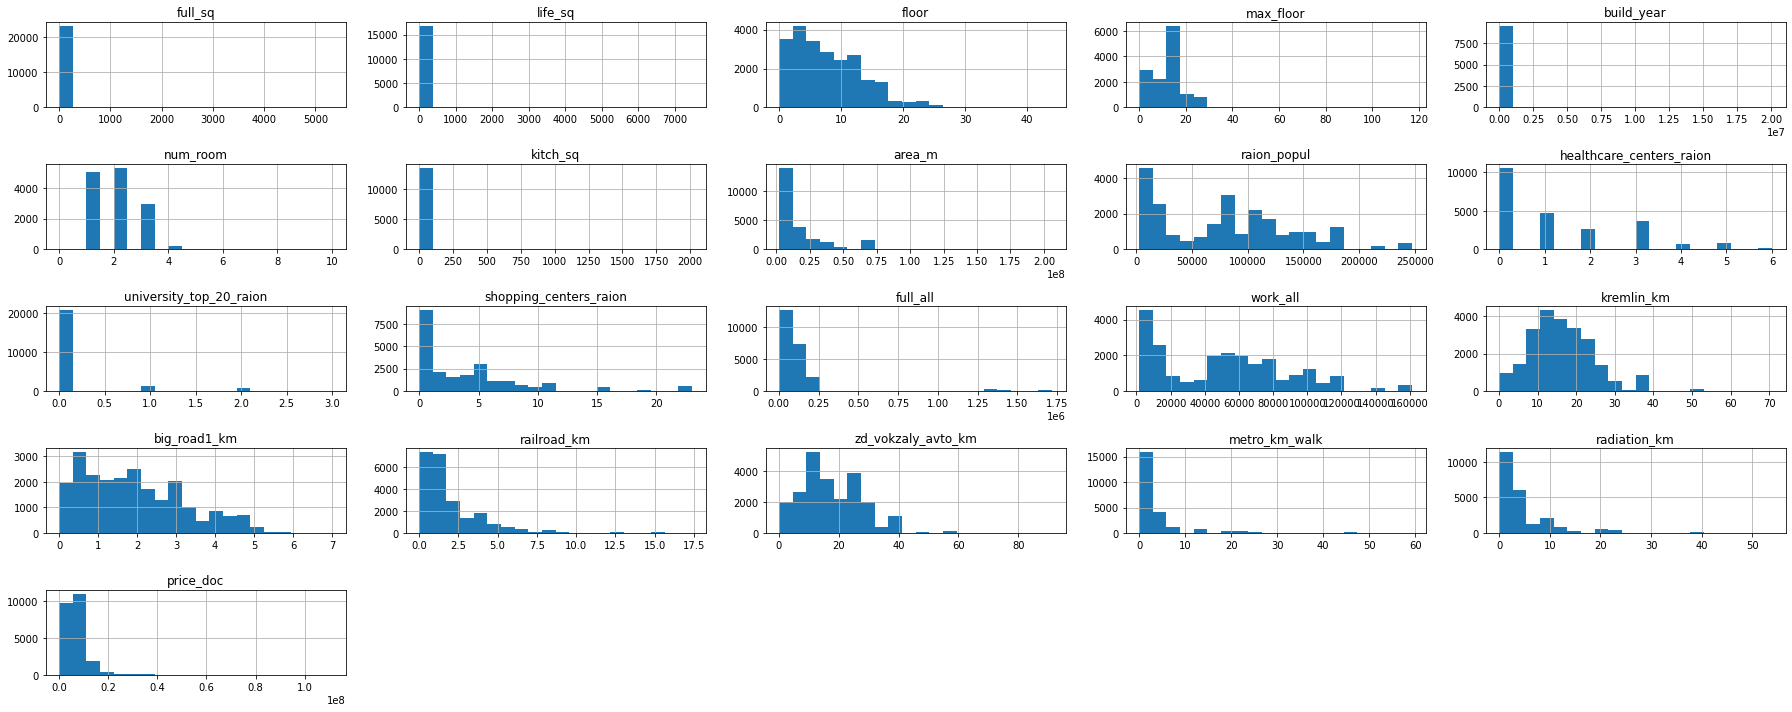

In [ ]:
# Distribuição usando hist() para ver o histograma de todas as variáveis ao mesmo tempo
fig = plt.figure(figsize=(25,10))
ax = plt.gca()
dados_treino.hist(ax=ax,bins=20)
plt.tick_params(axis='both',size=16) 
plt.tight_layout() # Para evitar sobreposições nos títulos
plt.show()

Alguma conclusão interessante sobre as distribuições das variáveis?

Como pudemos ver, muitas características chamam atenção no nosso dataset, especialmente em relação a tratamentos que serão necessários para nossa modelagem:
* `Outliers`, dados muito distantes das distribuições das variáveis e que podem afetar o treinamento dos nossos modelos
* `Escalas muito distintas`, como tamanho da residência (ordem de 100) e população (ordem de milhões).
* `Distribuições não normais`, assimétricas e que podem ser melhor aproveitadas com alguns tratamentos especiais
* `Variáveis não numéricas`, que precisão também de tratamentos se quisermos usá-las em modelos estatísticos
* `Valores faltantes`, sem as quais não conseguiremos modelar também. Então tratar é preciso!

### <center> A partir de agora, iremos abordar cada um desses temas, cada um com suas técnicas e segredos! :) 

## 2. Outliers: Dados fora do padrão

<center> <img src="https://pbs.twimg.com/media/EiiBY4hXYAAbP6d.png" width=1000>

Outliers são dados que **destoam dos demais**, o que podemos identificar com mais facilidade quando observamos a distribuição dos dados

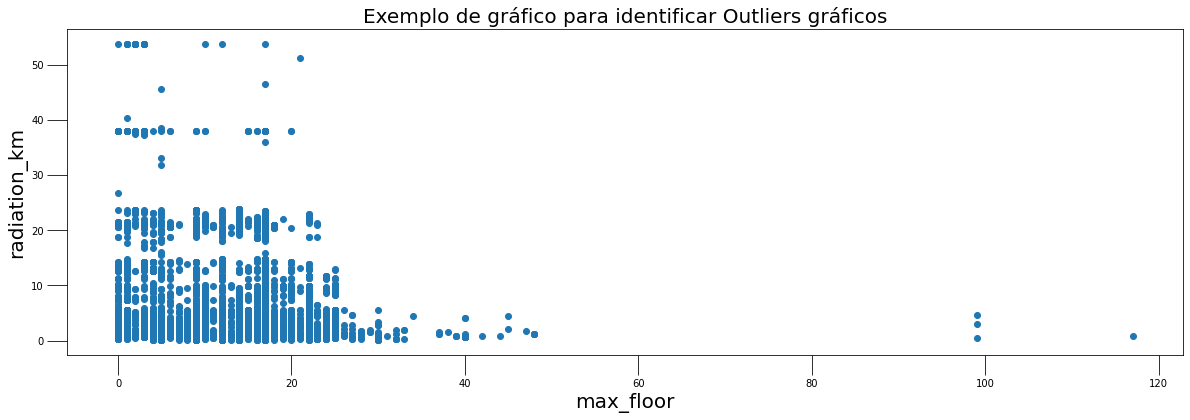

In [ ]:
# Gráfico de duas variáveis distintas, usando o plot do matplotlib
plt.figure(figsize=(20,6))
plt.scatter(dados_treino['max_floor'],dados_treino['radiation_km'])
plt.tick_params(axis='both',size=20)
plt.xlabel('max_floor',size=20)
plt.ylabel('radiation_km',size=20)
plt.title('Exemplo de gráfico para identificar Outliers gráficos',size=20)
plt.show()

Vamos analisar o ano de construção da casa:

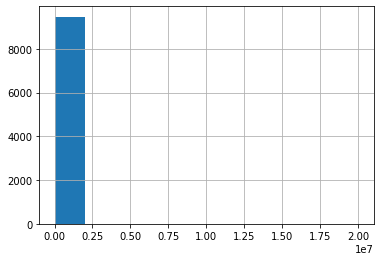

In [ ]:
# Distribuição do ano de construção
dados_treino.build_year.hist()
plt.show()

O gráfico tem quase todos os dados concentrados em ~2000, porém há um dado bastante distante dos demais!

In [ ]:
dados_treino[dados_treino.build_year>3000]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,nuclear_reactor_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc
15861,2013-08-27,37,16.0,8.0,12.0,1.0,20052009.0,1.0,9.0,33.0,Cheremushki,5467178.309,102618,3,0,6,no,130396,65782,8.883625,1.962649,2.903200,10.156672,0.764544,1.205309,9000000
17621,2014-02-19,41,24.0,4.0,9.0,2.0,4965.0,2.0,5.0,3.0,Sokolinaja Gora,7905261.321,85956,5,1,8,no,85083,55337,7.440979,2.648083,0.854339,5.194128,1.132308,0.768759,8400000


In [ ]:
# Aplicando o max para identificar o outlier mais facilmente
dados_treino[dados_treino.build_year<=3000].build_year.min()

0.0

O que podemos concluir sobre esse outlier?

Quando temos outliers nos nossos dados, precisamos primeiro `identificá-los` para então decidir `o que fazer com eles`. Existem várias formas diferentes de se detectar outliers, mas principalmente quando estamos no meio do processo de análise e modelagem, é conveniente ter na caixa de ferramentas formas **rápidas e fáceis** de identificar! Na aula de hoje, vamos aprender duas formas diferentes:
* Identificação por `z-score`
* Identificação por `Boxplots`

### Usando a distribuição normal e z-scores

Quando a distribuição da nossa variável é **normal**, sabemos que nossos dados são distribuídos em torno da média, sendo que temos uma boa estimativa do percentual de dados em torno da média em função do **desvio padrão**:

<center> <img src = "../0. MISC/normal.jpeg" width=1100 align=center>

Observando a distribuição normal mais de perto, podemos assumir que se um dado está `distante da média`, provavelmente ele é um outlier, certo? E como identificar isso? 

Podemos usar para isso o `z-score`, que é o número de desvios padrões que um dado está distante da média!

In [ ]:
# Selecionando apenas dados numéricos usando o .select_dtypes
dados_treino_num = dados_treino.select_dtypes(include=['int','float'])

# Importando a função que calcula score, do stats (não é a única)
from scipy.stats import zscore

# Calculando o z-score de cada dado em relação à distribuição da sua coluna
z_score = zscore(dados_treino_num)
z_score[0] # Apenas a primeira linha

array([        nan,         nan,         nan,         nan,         nan,
               nan, -0.57631198, -0.15956601, -0.37535669, -0.32860842,
       -0.3504855 ,         nan, -0.60475745])

In [ ]:
dados_treino_num.head(2)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,27.0,4.0,14.0,1980.0,2.0,6.0,6407578.100,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027
1,19.0,3.0,14.0,1980.0,2.0,6.0,9589336.912,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295


In [ ]:
pd.DataFrame(z_score,columns=dados_treino_num.columns).head(2)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,NaN,NaN,NaN,NaN,NaN,NaN,-0.576312,-0.159566,-0.375357,-0.328608,-0.350485,NaN,-0.604757
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.428994,-0.917001,0.747417,-0.629671,-0.828181,NaN,-0.338013


O array acima apresenta os `z_score` de todos os pontos na primeira coluna.


Podemos agora definir um limiar e comparar o nosso DataFrame original com estes valores:

In [ ]:
teste_z_score = np.abs(z_score) >= 3 # Dados a menos de 5 desvios padrões longe da média (abs=módulo)
teste_z_score

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Se quisermos manter apenas as linhas em que **todos** os dados estiverem dentro da distribuição esperada, podemos usar a função **.any()** do Pandas, que verifica se os registros de uma linha ou coluna são todos verdadeiros

In [ ]:
# Filtrando a base final   
dados_treino_no_out = dados_treino[~teste_z_score.any(axis=1)]

Como deixamos dados 'de fora', temos que ter ideia do quanto isso representou, pois podemos ter ido muito longe na exclusão dos dados

In [ ]:
# Tamanhos antes e depois de filtrar outliers
print('Tamanho antes de filtrar outliers '+str(len(dados_treino)))
print('Tamanho depois de filtrar outliers '+str(len(dados_treino_no_out)))

perc_nao_out = len(dados_treino_no_out)/len(dados_treino)*100

print('Percentual da base que mantivemos: {:.1f}%'.format(perc_nao_out))

Tamanho antes de filtrar outliers 23070
Tamanho depois de filtrar outliers 22037
Percentual da base que mantivemos: 95.5%


### E quando a distribuição não é normal?

Quando a distribuição da nossa variável é **normal**, sabemos que nossos dados são distribuídos em torno da média, sendo que temos uma boa estimativa do percentual de dados em torno da média em função do **desvio padrão**:

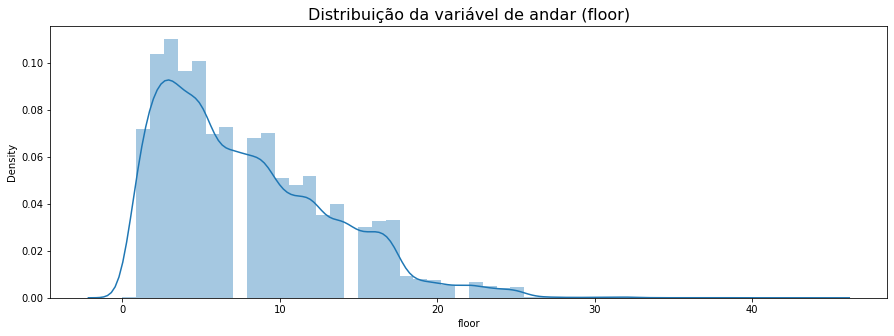

In [ ]:
# Plotndo um exemplo de distribuição não normal usando o distplot do Seaborn

# Andar do imóvel
plt.figure(figsize=(15,5))
sns.distplot(dados_treino.floor)
plt.title("Distribuição da variável de andar (floor)",size=16)
plt.show()

Neste caso, mesmo a média e o desvio padrão podem nos enganar por serem muito diferentes e não representarem a mesma coisa que em uma distribuição normal

In [ ]:
# Estatísticas da coluna, usando o .describe()
print("Média: {:.2f}".format(dados_treino.floor.mean()))
print("Mediana: {:.2f}".format(dados_treino.floor.median()))
print("Desvio Padrão: {:.2f}".format(dados_treino.floor.std()))

Média: 7.86
Mediana: 7.00
Desvio Padrão: 5.38


Temos aqui o caso de uma distribuição **assimétrica**, onde o método de z-score provavelmente falhará pois não temos 99% dos dados entre 3 desvios padrões:

<center> <img src="https://www.researchgate.net/profile/Matthieu-Komorowski-2/publication/308007227/figure/fig9/AS:405479382634502@1473685226485/51-Symmetrical-versus-asymmetrical-skewed-distribution-showing-mode-mean-and-median.png" width=1500>

Para contornar essa limitação do `z-score`, vamos usar outro tipo de visualização que já usamos antes para separar os outliers: o **BoxPlot**!

<center> <img src="https://miro.medium.com/max/1200/0*bsjTki4h_uNvkO2A.png" width=1700>

A `distância interquartil (IQR)` representa a diferença entre os percentis 75 e 25. Em particular, quando a distribuição é normal, temos apenas **0,3%** dos dados para além dos limites superior e inferior do boxplot:



<center> <img src="https://www.researchgate.net/publication/340996565/figure/fig3/AS:962186885210119@1606414638167/Box-plot-and-probability-density-function-of-a-normal-distribution.png" width=1200>

Podemos então calcular as distâncias interquartis da variável `floor` para excluir os outliers:

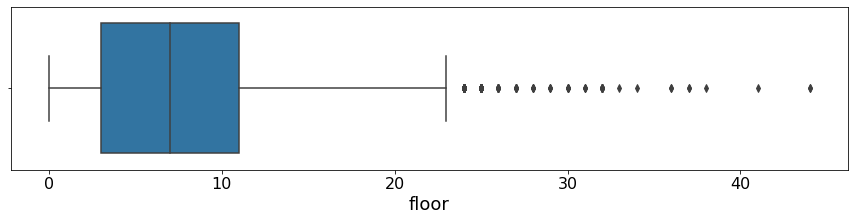

In [ ]:
# Plotando o boxplot
plt.figure(figsize=(15,3))
sns.boxplot(dados_treino.floor, showfliers=True)
plt.xticks(size=16)
plt.xlabel('floor',size=18)
plt.show()

In [ ]:
# Calculando as distâncias interquartis
q25_floor = dados_treino.floor.quantile(0.25)
q75_floor = dados_treino.floor.quantile(0.75)
iqr_floor = q75_floor-q25_floor
# Excluindo registros para além de 1,5*IQR
dados_treino_noout = dados_treino[(dados_treino.floor>=q25_floor-1.5*iqr_floor) & (dados_treino.floor<=q25_floor+1.5*iqr_floor)]
# Estatísticas finais da base
print('Tamanho da base antes da exclusão de outliers: {}'.format(len(dados_treino)))
print('Tamanho da base após a exclusão de outliers: {}'.format(len(dados_treino_noout)))
print('Perda percentual de registros: {:.1f}%'.format((len(dados_treino)-len(dados_treino_noout))/len(dados_treino)*100))

Tamanho da base antes da exclusão de outliers: 23070
Tamanho da base após a exclusão de outliers: 20515
Perda percentual de registros: 11.1%


Como a distribuição não é normal, o percentual de regitros identificados como outliers são maiores do que em uma distribuição normal, neste caso de 11%.

## 3. Missing values: Interpretando o que não existe

Apenas usando o método `.info()` já pudemos identificar que nossa base possui muitos missings! Como a maioria dos modelos não aceita dados faltantes, precisaremos tratar nossa base! <p>
    
Um bom primeiro passo é `identificar` nossos valores faltantes, o que pode ser feito usando o método `.isna()`

In [ ]:
dados_treino.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,nuclear_reactor_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,6.407578e+06,155572,1,0,16,no,86206,98207,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,9.589337e+06,115352,1,0,3,no,76284,70194,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Tekstil'shhiki,4.808270e+06,101708,1,0,0,no,101982,63388,9.067885,0.647250,0.700691,9.540544,1.445960,0.772216,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Mitino,1.258354e+07,178473,1,0,11,no,21155,120381,19.487005,2.677824,1.999265,17.478380,0.963802,6.348716,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Basmannoe,8.398461e+06,108171,4,2,10,no,28179,68043,2.578671,1.721834,0.084113,1.595898,0.688859,1.638318,16331452


In [ ]:
# Verificando a proporção de dados faltantes, aplicando a função .isna()
dados_treino.isna().head(5) # Apenas as primeiras linhas

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,nuclear_reactor_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc
0,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Como podemos ver, a função retorna `False (0)` quando dado é preenchido e `True (1)` quando o dado é faltante. Sendo assim, se tirarmos a média dessa nova base teremos o **percentual** de dados faltantes!

In [ ]:
a = [1,1,0,0]
soma = sum(a)
media = soma/4
media

0.5

In [ ]:
# Calculando o percentual de dados faltantes
dados_treino.isna().mean().sort_values(ascending=False)*100 # Também fazendo a ordenação decrescente pelo .sort_values()

build_year                  58.972692
state                       58.773299
max_floor                   41.491114
material                    41.491114
num_room                    41.491114
kitch_sq                    41.491114
life_sq                     27.667967
floor                        0.723884
metro_km_walk                0.108366
price_doc                    0.000000
area_m                       0.000000
full_sq                      0.000000
sub_area                     0.000000
raion_popul                  0.000000
radiation_km                 0.000000
healthcare_centers_raion     0.000000
university_top_20_raion      0.000000
shopping_centers_raion       0.000000
nuclear_reactor_raion        0.000000
full_all                     0.000000
work_all                     0.000000
kremlin_km                   0.000000
big_road1_km                 0.000000
railroad_km                  0.000000
zd_vokzaly_avto_km           0.000000
timestamp                    0.000000
dtype: float

Temos algumas colunas com muitos missings!

Sabemos que temos valores faltantes na base, mas como é a **distribuição** dos missings? Será que é um problema distribuído ao longo da base ou _concentrado_ em uma porção dos imóveis? Para respondermos a essa pergunta, usaremos mais uma vez a biblioteca `Missingno` para nos ajudar!
    
<center> <img src="https://2.bp.blogspot.com/-UOx5trnazKA/VtBRbGiIM4I/AAAAAAAAEJI/NHGRqK8ZB6M/w1200-h630-p-k-no-nu/missingno%2Bencontro.jpg" wodth=1800>
   

Caso não tenha a lib instalada, descomente a linha abaixo e rode a célula!

In [ ]:
#!pip install missingno

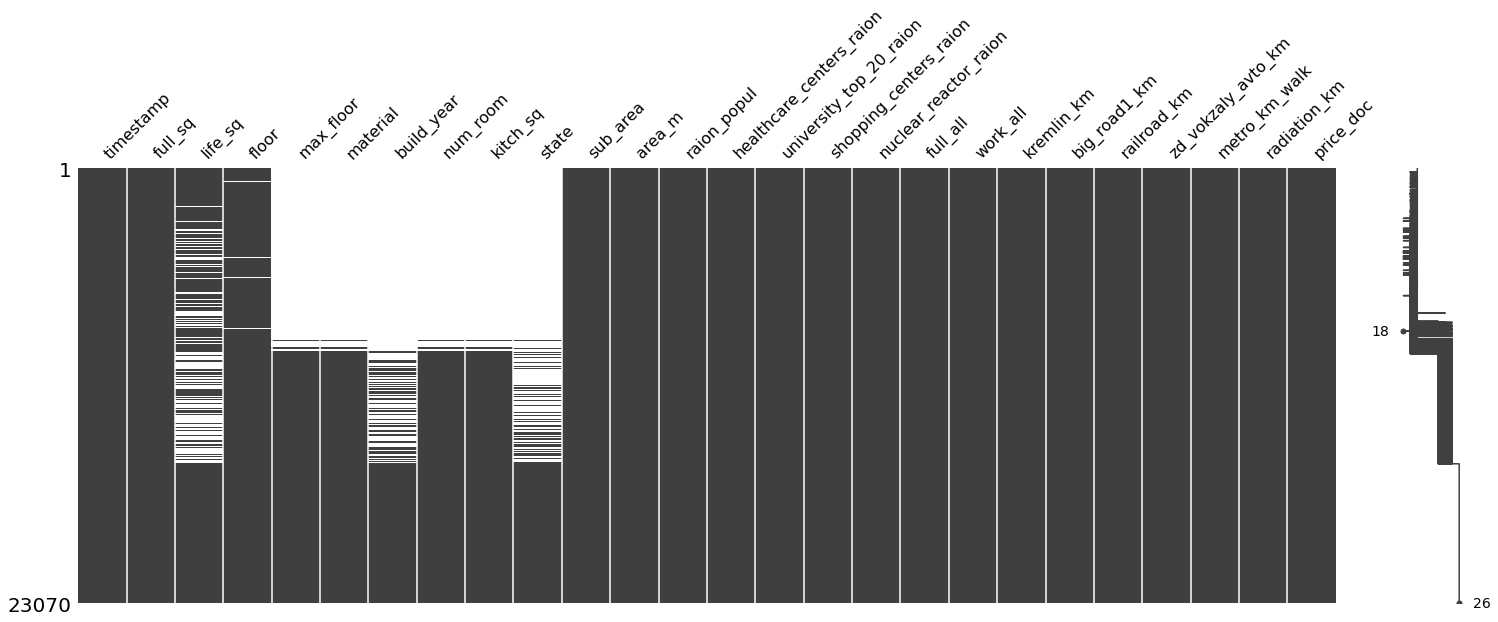

In [ ]:
import missingno as msno
# Para aplicar a matriz de missings, usamos a função matrix()
msno.matrix(dados_treino,figsize=(25,8))
plt.show()

O que podemos concluir sobre os valores faltantes na nossa base? E o que podemos fazer com eles?

A verdade é que valores faltantes ocorrem, mas sua origem pode estar relacionada a diferentes fatores; as principais fontes de erro são `MCAR`, `MAR` e `MNAR`:



Uma alternativa que temos é a de eliminar todos os registros em que temos dados faltantes usando o `dropna()`. Mas será que é viável para nosso problema?

In [ ]:
# Excluindo todas as linhas com dados faltantes
dados_treino_naofaltante = dados_treino.dropna()

# Tamanhos de base antes e depois
print('Tamanho da base antes da exclusão de missings: {}'.format(len(dados_treino)))
print('Tamanho da base após a exclusão de missings: {}'.format(len(dados_treino_naofaltante)))
print('Perda percentual de registros: {:.1f}%'.format((len(dados_treino)-len(dados_treino_naofaltante))/len(dados_treino)*100))

Tamanho da base antes da exclusão de missings: 23070
Tamanho da base após a exclusão de missings: 7401
Perda percentual de registros: 67.9%


Perderíamos muitos registros! E isso no fim pode afetar a performance do nosso modelo!

Para que não deixemos tantos dados de lado, podemos fazer o **preenchimento de campos faltantes** com valores que façam sentido com nossa realidade. Esse preenchimento parte do princípio de que os missings são **aleatórios**, e temos algumas formas diferentes de fazer esse preenchimento:
* Em campos numéricos, podemos usar estatísticas não enviesadas como **média** e **mediana**. Essas medidas podem ser calculadas tanto usando todo o dataset ou por grupo
* Em campos categóricos, podemos usar estatísticas similares como a **moda** (valor mais frequente)

In [ ]:
# Avaliando campos que possuem dados faltantes
campos_faltantes = dados_treino.isna().mean()
campos_faltantes = list(campos_faltantes[campos_faltantes>0].index) # Filtrando apenas as colunas que possuem missings

campos_faltantes

['life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'metro_km_walk']

Filtrando apenas os campos com missings, podemos analisar seus tipos e tratá-los de forma diferente:

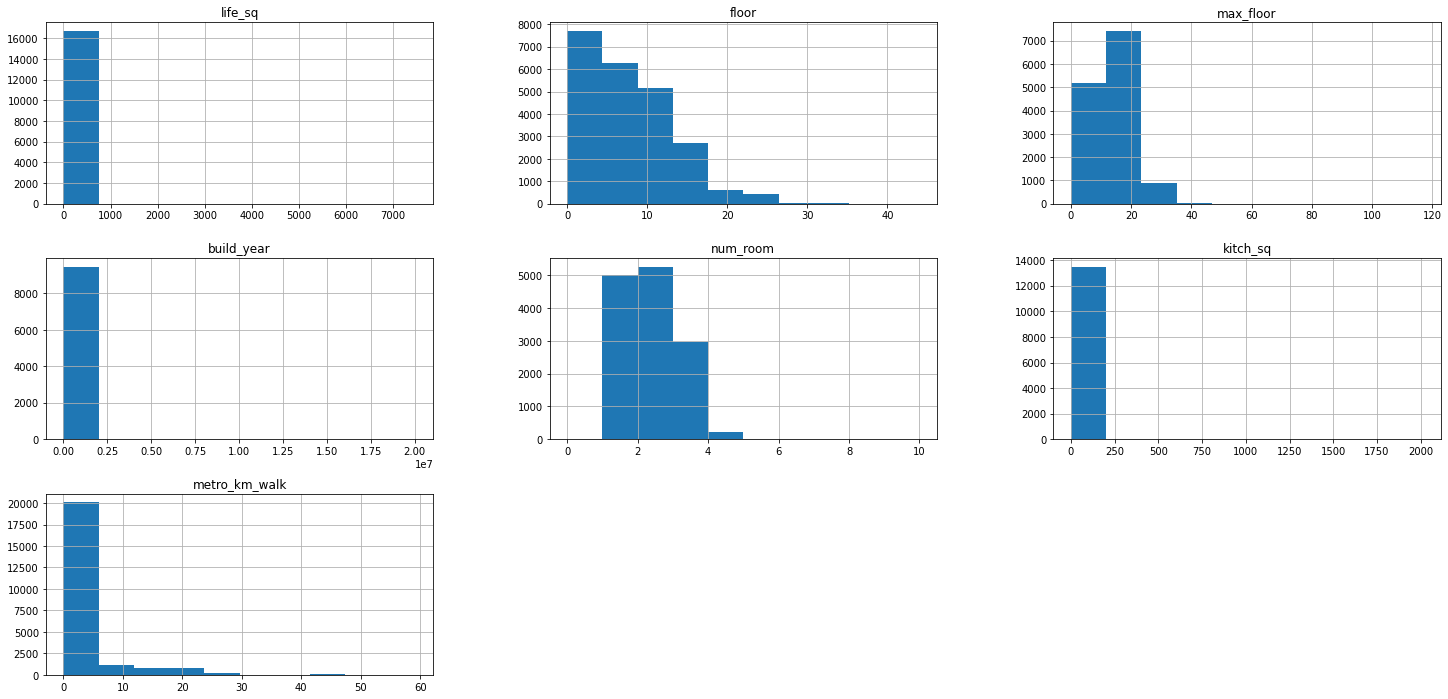

In [ ]:
dados_treino[campos_faltantes].hist(figsize=(25,12))
plt.tick_params(size=15)
plt.show()

### Tratando missings em variáveis numéricas

As variáveis `material` e `state` são categóricas, enquanto as demais são numéricas. Vamos começar tratando as variáveis numéricas

In [ ]:
# Selecionando todas as variáveis exceto 'state' e 'material'
campos_faltantes_cat = ['state','material']
campos_faltantes_num = set(campos_faltantes)-set(campos_faltantes_cat) # Quando usamos 'set' podemos 'subtrair' listas

Uma das formas mais eficientes de preenhcimento de missings no `Pandas` é usando a função `fillna()`, que preenche os valores faltantes segundo uma regra

In [ ]:
# Preenchendo com 0
dados_treino[campos_faltantes_num].fillna(0).head() # E mostrando apenas as 5 primeiras linhas 

,kitch_sq,build_year,num_room,max_floor,life_sq,floor,metro_km_walk
0,0.0,0.0,0.0,0.0,27.0,4.0,1.131260
1,0.0,0.0,0.0,0.0,19.0,3.0,0.635053
2,0.0,0.0,0.0,0.0,29.0,2.0,1.445960
3,0.0,0.0,0.0,0.0,50.0,9.0,0.963802
4,0.0,0.0,0.0,0.0,77.0,4.0,0.688859


A função `fillna()` também possui preenchimentos segundo algum método, como a **média** e **mediana** que comentamos

In [ ]:
# Preenchendo com a média
dados_treino[campos_faltantes_num].fillna(dados_treino[campos_faltantes_num].median()).head() # E mostrando as primeiras 5 linhas

,kitch_sq,build_year,num_room,max_floor,life_sq,floor,metro_km_walk
0,6.0,1980.0,2.0,14.0,27.0,4.0,1.131260
1,6.0,1980.0,2.0,14.0,19.0,3.0,0.635053
2,6.0,1980.0,2.0,14.0,29.0,2.0,1.445960
3,6.0,1980.0,2.0,14.0,50.0,9.0,0.963802
4,6.0,1980.0,2.0,14.0,77.0,4.0,0.688859


Mas como o `fillna()` entendeu o argumento? Quando aplicamos o `.mean()` no dataset, ele nos retorna a média por coluna, certo?

In [ ]:
# Apenas fazendo a média por coluna, daquelas que possuem dados faltantes
dados_treino[campos_faltantes_num].median()

kitch_sq            6.000000
build_year       1980.000000
num_room            2.000000
max_floor          14.000000
life_sq            30.000000
floor               7.000000
metro_km_walk       1.791193
dtype: float64

O que o `Pandas` fez foi associar automaticamente cada nome de coluna com o valor a ser preenchido!

A mesma lógica poderia ser aplicada para preenchermos com a mediana. Mas qual é o impacto real dessa diferença? Vamos comparar o preenchimento com a média e com a mediana para a variável `max_floor`, o andar máximo do prédio da residência

A média da coluna max_floor é 12.70 e sua mediana é 14.00


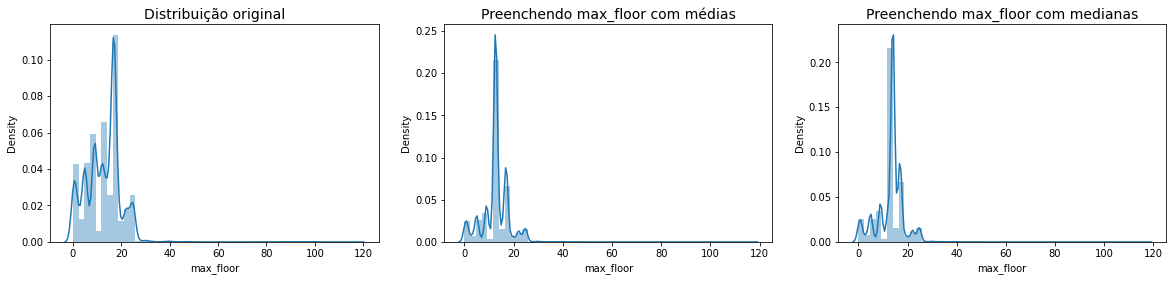

In [ ]:
coluna = 'max_floor'
# Preenchendo os valores faltantes da variável floor com a média, e plotando sua distribuição
preenchimento_com_media = dados_treino[coluna].fillna(dados_treino[coluna].mean())
preenchimento_com_mediana = dados_treino[coluna].fillna(dados_treino[coluna].median())
# Plotando as distribuições
fig, ax = plt.subplots(1,3,figsize=(20,4))
sns.distplot(dados_treino[coluna],ax=ax[0])
sns.distplot(preenchimento_com_media,ax=ax[1])
sns.distplot(preenchimento_com_mediana,ax=ax[2])
ax[0].set_title('Distribuição original',size=14)
ax[1].set_title('Preenchendo {} com médias'.format(coluna),size=14)
ax[2].set_title('Preenchendo {} com medianas'.format(coluna),size=14)
print("A média da coluna {} é {:.2f} e sua mediana é {:.2f}"
      .format(coluna,dados_treino[coluna].mean(),dados_treino[coluna].median()))
plt.show()

O fato de existirem **outliers** afeta bastante nosso processo de preenchimento! Nesse sentido, a mediana é mais robusta a outliers do que a média

### Tratando missings em variáveis categóricas

Em variáveis categóricas não podemos calcular estatísticas como a média e a mediana. Como então preencher missings desse tipo de informação? Vamos começar analisando as duas variáveis categóricas com valores faltantes que temos, `state` e `material`

In [ ]:
# Como são variáveis categóricas, uma análise simples é a contagem de registros por tipo
dados_treino.state.value_counts(normalize=True)*100 # Já normalizando para converter em percentuais

1.0     36.042477
2.0     31.258543
3.0     30.375355
4.0      2.313111
33.0     0.010514
Name: state, dtype: float64

In [ ]:
# Como são variáveis categóricas, uma análise simples é a contagem de registros por tipo
dados_treino.material.value_counts(normalize=True)*100 # Já normalizando para converter em percentuais

1.0    70.603052
2.0    12.505556
4.0     6.712105
5.0     6.223144
6.0     3.948733
3.0     0.007409
Name: material, dtype: float64

Apesar dos valores serem numéricos, não podemos interpretá-los pelo valor em sí, pois em ambos os casos são apenas códigos! Como então preencher os valores faltantes?

Para variáveis categóricas, podemos usar a `moda`, que é o valor **mais frequente** da distribuição

In [ ]:
dados_treino_categorico = dados_treino[['state','material']].astype('category')

# Preenchendo valores faltantes de _state_ e _material_ com suas respectivas modas
dados_treino_cat_preenchido = dados_treino_categorico.fillna(dados_treino_categorico.mode().iloc[0])

# Comparando missings antes e depois
print('Missings no dataset original: {}'.format(dados_treino_categorico.state.isna().sum()))
print('Missings no dataset tratado: {}'.format(dados_treino_cat_preenchido.state.isna().sum()))

Missings no dataset original: 13559
Missings no dataset tratado: 0


Com os valores preenchidos, podemos agora comparar como ficou a nossa distribuição antes e depois do tratamento:

In [ ]:
dados_treino.sub_area.value_counts()

Poselenie Sosenskoe               1607
Nekrasovka                        1416
Poselenie Vnukovskoe              1225
Poselenie Moskovskij               842
Poselenie Voskresenskoe            652
Tverskoe                           583
Mitino                             512
Poselenie Filimonkovskoe           421
Krjukovo                           402
Poselenie Shherbinka               375
Solncevo                           351
Zapadnoe Degunino                  344
Mar'ino                            336
Juzhnoe Butovo                     309
Poselenie Desjonovskoe             304
Otradnoe                           262
Nagornoe                           238
Tekstil'shhiki                     224
Nagatinskij Zaton                  221
Izmajlovo                          221
Ljublino                           215
Gol'janovo                         214
Strogino                           214
Bogorodskoe                        210
Severnoe Tushino                   207
Chertanovo Juzhnoe       

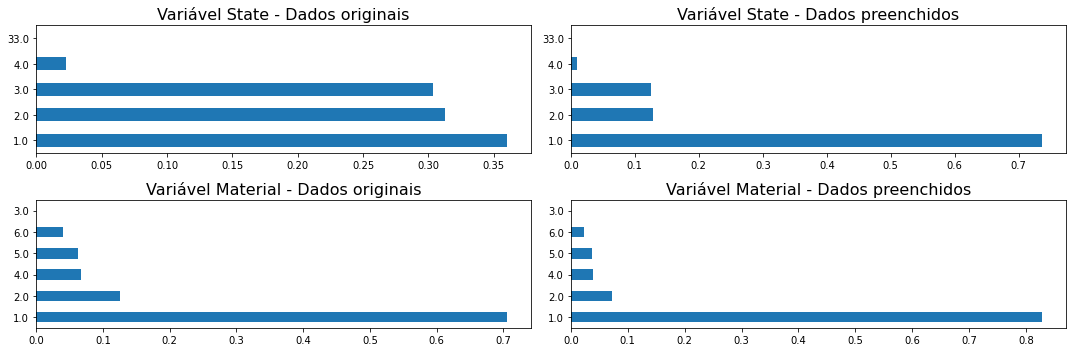

In [ ]:
# Avaliando as distribuições de _state_ e _material_ antes e depois
fig, ax = plt.subplots(2,2,figsize=(15,5))
# State
dados_treino_categorico.state.value_counts(normalize=True).plot(kind='barh',ax=ax[0][0])
dados_treino_cat_preenchido.state.value_counts(normalize=True).plot(kind='barh',ax=ax[0][1])
ax[0][0].set_title('Variável State - Dados originais',size=16)
ax[0][1].set_title('Variável State - Dados preenchidos',size=16)
# Material
dados_treino_categorico.material.value_counts(normalize=True).plot(kind='barh',ax=ax[1][0])
dados_treino_cat_preenchido.material.value_counts(normalize=True).plot(kind='barh',ax=ax[1][1])
ax[1][0].set_title('Variável Material - Dados originais',size=16)
ax[1][1].set_title('Variável Material - Dados preenchidos',size=16)
plt.tight_layout() # Para evitar sobreposição
plt.show()

Quando preenchemos valores faltantes de uma variável categórica com a **moda**, reforçamos a importância do valor mais frequente na distribuição!

### `SimpleImputer`: Automatizando o processo!

Agora que sabemos os princípios por trás do preenchimento de valores faltantes, podemos usar funções e bibliotecas que facilitam nosso trabalho! No `scikit-learn`, uma das melhores funções disponíveis é o **SimpleImputer**

In [ ]:
# Importando e instanciando um SimpleImputer
from sklearn.impute import SimpleImputer

imputer_numericos = SimpleImputer(strategy='median') # Para preencher dados numéricos com a mediana
imputer_categoricos = SimpleImputer(strategy='most_frequent') # Para preencher dados categoricos com a moda

Na estrutura do `scikit-learn`, (quase) todos os objetos possuem a mesma estrutura:
* No momento de instanciar o objeto, definimos os parâmetros que serão usados na função (hiperparâmetros)
* Para ajustarmos o objeto aos nossos dados, aplicamos o comando `.fit()`
* Se quisermos aplicar o resultado do nosso transformador a dados novos, usamos o comando `.transform()`
* Podemos ainda aplicar em sequência o ajuste e a transformação, usando o comando `.fit_transform()`

Vamos agora ajustar o nosso Imputador aos nossos dados

In [ ]:
# Ajudando os imputadores aos dados
imputer_numericos.fit(dados_treino[campos_faltantes_num])
imputer_categoricos.fit(dados_treino[campos_faltantes_cat])

SimpleImputer(strategy='most_frequent')

In [ ]:
# Transformando o dataset com o imputer
dados_treino_num.loc[:,campos_faltantes_num] = imputer_numericos.transform(dados_treino[campos_faltantes_num])
dados_treino_categorico.loc[:,campos_faltantes_cat] = imputer_categoricos.transform(dados_treino[campos_faltantes_cat])

# Unindo os dois datasets novamente, usando concat!
dados_treino_preenchido = pd.concat([dados_treino_num,dados_treino_categorico],axis=1) # axis=1 significa unindo na horizontal

# Avaliando missings
dados_treino_num.isna().sum()

life_sq               0
floor                 0
max_floor             0
build_year            0
num_room              0
kitch_sq              0
area_m                0
kremlin_km            0
big_road1_km          0
railroad_km           0
zd_vokzaly_avto_km    0
metro_km_walk         0
radiation_km          0
dtype: int64

Agora não temos mais missings na base!

## 4. Variáveis categóricas: Como converter classes em números?

Em muitos datasets podemos encontrar informações que ou não são numéricas ou podem não ser interpretadas como números, e isso pode atrapalhar nosso processo de modelagem! Vamos começar identificando esse tipo de variável em nosso dataset, usando o método `.select_dtypes()` para nos ajudar

In [ ]:
dados_treino.nuclear_reactor_raion.value_counts()

no     22503
yes      567
Name: nuclear_reactor_raion, dtype: int64

In [ ]:
# Filtrando variáveis não numéricas, ou seja, tudo o que não é _int_ ou _float
dados_treino_cat = dados_treino.select_dtypes(exclude=['int64','float'])

# Informação das colunas restantes
dados_treino_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23070 entries, 0 to 23069
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   timestamp              23070 non-null  object
 1   material               13498 non-null  object
 2   state                  9511 non-null   object
 3   sub_area               23070 non-null  object
 4   nuclear_reactor_raion  23070 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [ ]:
# Apresentando uma amostra dos dados categóricos
dados_treino_cat.tail()

,timestamp,material,state,sub_area,nuclear_reactor_raion
23065,2015-06-29,1.0,2.0,Mitino,no
23066,2015-06-29,1.0,2.0,Jasenevo,no
23067,2015-06-30,1.0,3.0,Severnoe Tushino,no
23068,2015-06-30,2.0,3.0,Tverskoe,no
23069,2015-06-30,1.0,2.0,Obruchevskoe,no


Para converter variáveis numéricas em categóricas, uma alternativa muito utilizada é o conceito de `One Hot Encoding`, onde criamos novas colunas e cada uma delas indica se o registro pertence a uma determinada classe ou não

<center> <img src="https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png" width=2000>

No `scikit-learn`, a função que nos permite fazer essa transformação é o `OneHotEncoding`

In [ ]:
# Importando e instanciando um One Hot Encoder
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Assim como em outros objetos do scikit-learn, também contamos com os métodos .fit() e .transform()
ohe.fit(dados_treino[['state','material','nuclear_reactor_raion']])

# O resultado da transformação será um array
dados_treino_ohe = ohe.transform(dados_treino[['state','material','nuclear_reactor_raion']]).todense()
dados_treino_ohe

matrix([[0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        ...,
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.]])

In [ ]:
pd.DataFram

Para adicionarmos essas novas colunas ao nosso dataset, precisamos criar um dataframe com os nomes das colunas indicando as variáveis convertidas e seus valores. Os nomes das colunas podem ser acessados usando o método `.get_feature_names_out()`

In [ ]:
# Convertendo o resultado da transformação em um dataframe
df_dados_treino_ohe = pd.DataFrame(dados_treino_ohe,columns=ohe.get_feature_names_out()) # Pega o nome das colunas
 
# Mostrando o resultado
df_dados_treino_ohe.head()

,state_1.0,state_2.0,state_3.0,state_33.0,state_4.0,state_nan,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,material_nan,nuclear_reactor_raion_no,nuclear_reactor_raion_yes
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Para finalizar a transformação, precisamos unir nosso novo dataset à base de treino e excluir as variáveis originais categóricas

In [ ]:
colunas_a_excluir = ['state','material','nuclear_reactor_raion']

# Unindo os datasets
dados_treino_encod = pd.concat([dados_treino,df_dados_treino_ohe],axis=1)
# Excluindo as colunas originais
dados_treino_encod.drop(colunas_a_excluir,axis=1,inplace=True)

# Mostrando o dataset final
dados_treino_encod.head()

,timestamp,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc,state_1.0,state_2.0,state_3.0,state_33.0,state_4.0,state_nan,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,material_nan,nuclear_reactor_raion_no,nuclear_reactor_raion_yes
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,Bibirevo,6.407578e+06,155572,1,0,16,86206,98207,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027,5850000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,Nagatinskij Zaton,9.589337e+06,115352,1,0,3,76284,70194,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295,6000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,Tekstil'shhiki,4.808270e+06,101708,1,0,0,101982,63388,9.067885,0.647250,0.700691,9.540544,1.445960,0.772216,5700000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,Mitino,1.258354e+07,178473,1,0,11,21155,120381,19.487005,2.677824,1.999265,17.478380,0.963802,6.348716,13100000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,Basmannoe,8.398461e+06,108171,4,2,10,28179,68043,2.578671,1.721834,0.084113,1.595898,0.688859,1.638318,16331452,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## 5. Normalização: Adequando a importância das features

Em um dataset diverso, podemos ter features de todas as escalas possíveis, e no caso do nosso dataset não é diferente. Temos features na casa das dezenas (`full_sq`,`life_sq`), milhares (`raion_popul`) e ainda milhões (`area_m`)

In [ ]:
# Avaliando a ordem de grandeza das variáveis
print("Média da variável full_sq: {:.2f}".format(dados_treino.full_sq.mean()))
print("Média da variável raion_popul: {:.2f}".format(dados_treino.raion_popul.mean()))
print("Média da variável area_m: {:.2f}".format(dados_treino.area_m.mean()))

Média da variável full_sq: 54.44
Média da variável raion_popul: 79332.94
Média da variável area_m: 18854688.28


E o que acontece quando treinamos modelos com variáveis de escalas diferentes? É fácil perceber quando lembramos o princípio por trás da regressão linear, o algoritmo que já sabemos como aplicar e treinar com dados novos:

<center> <img src="https://www.alura.com.br/artigos/assets/desvendando-a-regressao-linear/imagem4.png" width=1200>

### Estratégias de normalização

Há múltiplas estratégias que podemos usar para tornar todos os dados comparáveis na mesma escala. Vamos entender e aplicar três métodos diferentes:
* O `MinMaxScaler` que considera valores máximos e mínimos da coluna
* `StandardScaler`, normalizando em função do desvio padrão da coluna
* E o `RobustScaler` que funciona usando os Intervalos interquartis (IQR) 

In [ ]:
# Importando os métodos de escala, todos pertencentes ao módulo _preprocessing_ do sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

Para aplicarmos os processos de escala, iremos seguir a estrutura padrão do `scikit-learn` que inclui instanciarmos o objeto e aplicarmos as funções `.fit()` e `.transform()`:

In [ ]:
# Instanciando os objetos de normalização
minmax_sc = MinMaxScaler()
standard_sc = StandardScaler()
robust_sc = RobustScaler()

### `MinMaxScaler`
Vamos começar aplicando a transformação do `MinMaxScaler`, que aplica uma função aos nossos dados numéricos restringindo os valores possíveis da coluna entre `0` e `1`:

<center> <img src="https://i.stack.imgur.com/EuitP.png">

In [ ]:
# Aplicando o MinMaxScaler aos dados
minmax_sc.fit(dados_treino_num)
minmax_sc.transform(dados_treino_num)

array([[0.00361059, 0.09090909, 0.11965812, ..., 0.15475957, 0.01896775,
        0.02236899],
       [0.00254079, 0.06818182, 0.11965812, ..., 0.09997843, 0.01059446,
        0.05047058],
       [0.00387804, 0.04545455, 0.11965812, ..., 0.10324989, 0.02427817,
        0.01424415],
       ...,
       [0.00387804, 0.29545455, 0.11965812, ..., 0.17587029, 0.0118456 ,
        0.04702406],
       [0.00788981, 0.06818182, 0.07692308, ..., 0.00959307, 0.01306093,
        0.03167101],
       [0.00427922, 0.11363636, 0.12820513, ..., 0.16652281, 0.03442574,
        0.01325062]])

Como vimos na aplicação do `OneHotEncoder`, o resultado da aplicação é um `Array` e não um `DataFrame` como estamos acostumados. Mas podemos resolver isso facilmente construindo um DataFrame com o resultado da aplicação:

In [ ]:
# Transformando o resultado em um dataframe
dados_treino_sc = pd.DataFrame(minmax_sc.transform(dados_treino_num),columns=dados_treino_num.columns)

# Mostrando o dataset resultante 
dados_treino_sc.head(3)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,0.003611,0.090909,0.119658,0.000099,0.2,0.002979,0.021207,0.213446,0.203290,0.074942,0.154760,0.018968,0.022369
1,0.002541,0.068182,0.119658,0.000099,0.2,0.002979,0.036804,0.122055,0.412722,0.039818,0.099978,0.010594,0.050471
2,0.003878,0.045455,0.119658,0.000099,0.2,0.002979,0.013367,0.127289,0.092478,0.040172,0.103250,0.024278,0.014244


Todas as colunas agora estão entre os valores de `0` e `1`, e podemos confirmar isso pelo `.describe()`

In [ ]:
dados_treino_sc.agg(['min','max'])

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Apenas como comparativo, vamos mostrar também o dataframe original

In [ ]:
dados_treino_sc.head(3)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,0.003611,0.090909,0.119658,0.000099,0.2,0.002979,0.021207,0.213446,0.203290,0.074942,0.154760,0.018968,0.022369
1,0.002541,0.068182,0.119658,0.000099,0.2,0.002979,0.036804,0.122055,0.412722,0.039818,0.099978,0.010594,0.050471
2,0.003878,0.045455,0.119658,0.000099,0.2,0.002979,0.013367,0.127289,0.092478,0.040172,0.103250,0.024278,0.014244


In [ ]:
dados_treino_num.head(3)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,27.0,4.0,14.0,1980.0,2.0,6.0,6407578.100,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027
1,19.0,3.0,14.0,1980.0,2.0,6.0,9589336.912,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295
2,29.0,2.0,14.0,1980.0,2.0,6.0,4808269.831,9.067885,0.647250,0.700691,9.540544,1.445960,0.772216


Um aspecto interessante do `MinMaxScaler` é que a forma da distribuição permanece a mesma, apenas os valores mínimo e máximo que são alterados

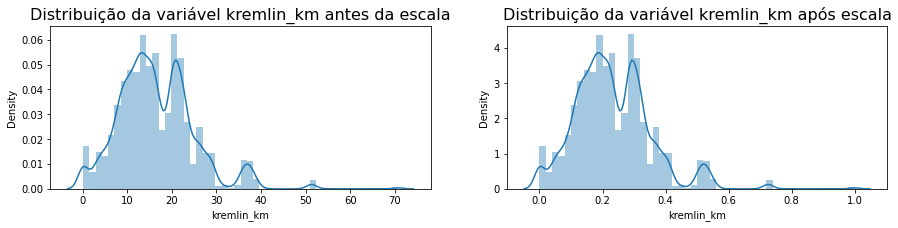

In [ ]:
coluna = 'kremlin_km'
# Comparando as distribuições de uma das variáveis antes e depois da aplicação do _MinMaxScaler_
fig,ax = plt.subplots(1,2,figsize=(15,3))
sns.distplot(dados_treino_num[coluna],ax=ax[0])
sns.distplot(dados_treino_sc[coluna],ax=ax[1])
ax[0].set_title('Distribuição da variável {} antes da escala'.format(coluna),size=16)
ax[1].set_title('Distribuição da variável {} após escala'.format(coluna),size=16)
plt.show()

### `StandardScaler`
No `StandardScaler`, normalizamos a coluna calculando o `z-score` que vimos antes no tratamento de outlers. A ideia é converter as distribuções para que eles tenham média `0` e desvio padrão `1`:

<center> <img src="https://media.geeksforgeeks.org/wp-content/uploads/standardisation.jpg" width=1000>

In [ ]:
# Aplicando o StandardScaler aos dados
standard_sc.fit(dados_treino_num)
standard_sc.transform(dados_treino_num)

array([[-0.12066984, -0.71836405,  0.14029101, ..., -0.3504855 ,
        -0.44043567, -0.60475745],
       [-0.2740766 , -0.90493006,  0.14029101, ..., -0.82818118,
        -0.52541557, -0.33801294],
       [-0.08231815, -1.09149607,  0.14029101, ..., -0.79965382,
        -0.38654055, -0.6818797 ],
       ...,
       [-0.08231815,  0.96073004,  0.14029101, ..., -0.16639838,
        -0.51271785, -0.37072782],
       [ 0.49295718, -0.90493006, -0.78105769, ..., -1.61634838,
        -0.50038354, -0.51646133],
       [-0.02479062, -0.53179804,  0.32456075, ..., -0.24790911,
        -0.28355358, -0.6913104 ]])

Como vimos na aplicação do `OneHotEncoder`, o resultado da aplicação é um `Array` e não um `DataFrame` como estamos acostumados. Mas podemos resolver isso facilmente construindo um DataFrame com o resultado da aplicação:

In [ ]:
# Transformando o resultado em um dataframe
dados_treino_std_sc = pd.DataFrame(standard_sc.transform(dados_treino_num),columns=dados_treino_num.columns)

# Mostrando o dataset resultante 
dados_treino_std_sc.head(3)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,-0.120670,-0.718364,0.140291,-0.006211,0.104101,0.001957,-0.576312,-0.159566,-0.375357,-0.328608,-0.350485,-0.440436,-0.604757
1,-0.274077,-0.904930,0.140291,-0.006211,0.104101,0.001957,-0.428994,-0.917001,0.747417,-0.629671,-0.828181,-0.525416,-0.338013
2,-0.082318,-1.091496,0.140291,-0.006211,0.104101,0.001957,-0.650361,-0.873626,-0.969430,-0.626636,-0.799654,-0.386541,-0.681880


In [ ]:
dados_treino.head(3)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,nuclear_reactor_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,6407578.100,155572,1,0,16,no,86206,98207,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,9589336.912,115352,1,0,3,no,76284,70194,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Tekstil'shhiki,4808269.831,101708,1,0,0,no,101982,63388,9.067885,0.647250,0.700691,9.540544,1.445960,0.772216,5700000


Vamos comparar a forma das distribuições antes e depois das mudanças para algumas colunas:

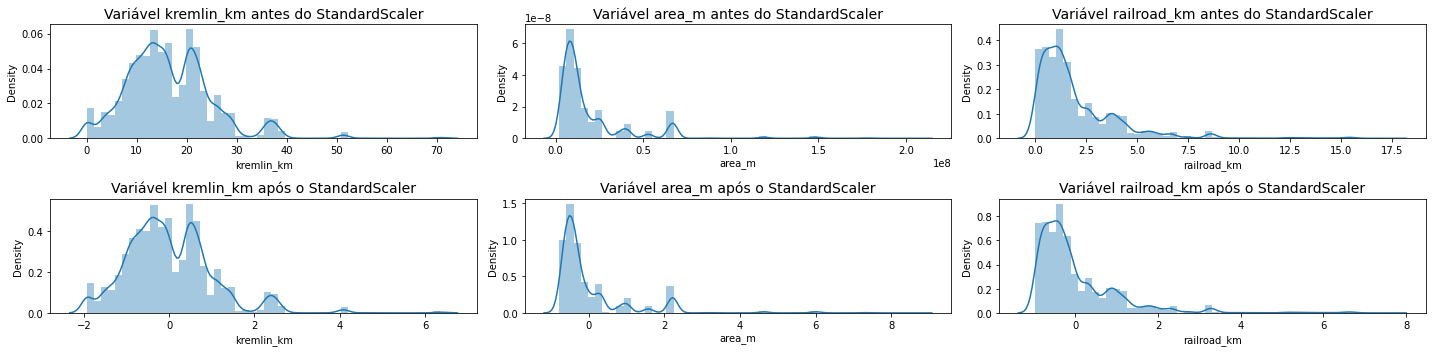

In [ ]:
# Comparando as distribuições de algumas das colunas
colunas_a_analisar = ['kremlin_km','area_m','railroad_km']

# Plotando os gráficos antes e depois
fig, ax = plt.subplots(2,3,figsize=(20,5))
for i in colunas_a_analisar:
    sns.distplot(dados_treino_num[i],ax=ax[0][colunas_a_analisar.index(i)])
    sns.distplot(dados_treino_std_sc[i],ax=ax[1][colunas_a_analisar.index(i)])
    ax[0][colunas_a_analisar.index(i)].set_title('Variável {} antes do StandardScaler'.format(i),size=14)
    ax[1][colunas_a_analisar.index(i)].set_title('Variável {} após o StandardScaler'.format(i),size=14)
plt.tight_layout()

As distribuições de três variáveis diferentes agora orbitam entre média 0 e desvio padrão 1, e agora suas importâncias em uma regressão linear dependeriam apenas da sua relação de fato com a variável resposta, e não com a sua ordem de grandeza.

### `RobustScaler`

Apesar de normalizarem os dados, as funções de escala que vimos até agora continuam afetadas por outliers. Mas o `RobustScaler` consegue ao mesmo tempo aplicar escala e atenuar o efeito dos outliers ao considerar como limites inferior e superrior os `Intervalor InterQuartis (IQR)` das variáveis!

<center> <img src="https://i.stack.imgur.com/G3V7C.png" width=1200>

In [ ]:
# Aplicando o StandardScaler aos dados
robust_sc.fit(dados_treino_num)
robust_sc.transform(dados_treino_num)

array([[-0.23076923, -0.42857143,  0.        , ..., -0.09629545,
        -0.23676735, -0.37402014],
       [-0.84615385, -0.57142857,  0.        , ..., -0.44723281,
        -0.41479411, -0.00304909],
       [-0.07692308, -0.71428571,  0.        , ..., -0.42627529,
        -0.12386098, -0.48127679],
       ...,
       [-0.07692308,  0.85714286,  0.        , ...,  0.03894347,
        -0.38819331, -0.04854683],
       [ 2.23076923, -0.57142857, -1.25      , ..., -1.02625692,
        -0.36235382, -0.25122359],
       [ 0.15384615, -0.28571429,  0.25      , ..., -0.02093809,
         0.09188929, -0.4943924 ]])

Como vimos na aplicação do `OneHotEncoder`, o resultado da aplicação é um `Array` e não um `DataFrame` como estamos acostumados. Mas podemos resolver isso facilmente construindo um DataFrame com o resultado da aplicação:

In [ ]:
# Transformando o resultado em um dataframe
dados_treino_rob_sc = pd.DataFrame(robust_sc.transform(dados_treino_num),columns=dados_treino_num.columns)

# Mostrando o dataset resultante 
dados_treino_rob_sc.head(3)

,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km
0,-0.230769,-0.428571,0.0,0.0,0.0,0.0,-0.343103,-0.034391,-0.160398,0.020719,-0.096295,-0.236767,-0.374020
1,-0.846154,-0.571429,0.0,0.0,0.0,0.0,-0.118825,-0.633532,0.568305,-0.303541,-0.447233,-0.414794,-0.003049
2,-0.076923,-0.714286,0.0,0.0,0.0,0.0,-0.455836,-0.599221,-0.545964,-0.300272,-0.426275,-0.123861,-0.481277


Vamos comparar a forma das distribuições antes e depois das mudanças para algumas colunas:

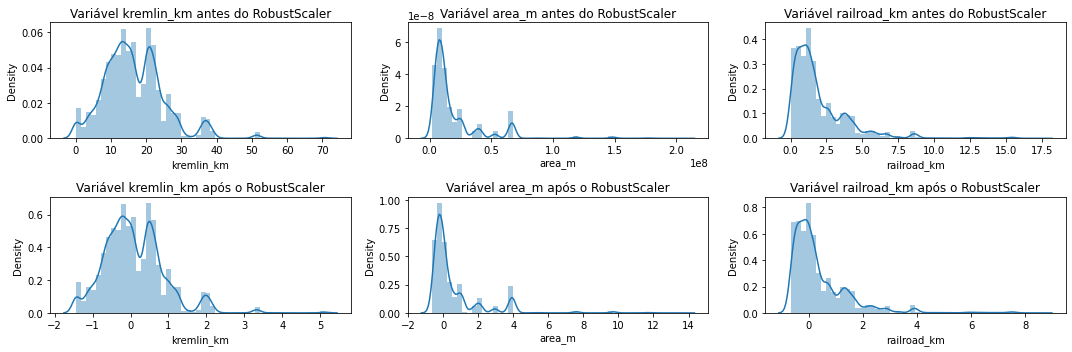

In [ ]:
# Comparando as distribuições de algumas das colunas
colunas_a_analisar = ['kremlin_km','area_m','railroad_km']

# Plotando os gráficos antes e depois
fig, ax = plt.subplots(2,3,figsize=(15,5))
for i in colunas_a_analisar:
    sns.distplot(dados_treino_num[i],ax=ax[0][colunas_a_analisar.index(i)])
    sns.distplot(dados_treino_rob_sc[i],ax=ax[1][colunas_a_analisar.index(i)])
    ax[0][colunas_a_analisar.index(i)].set_title('Variável {} antes do RobustScaler'.format(i))
    ax[1][colunas_a_analisar.index(i)].set_title('Variável {} após o RobustScaler'.format(i))
plt.tight_layout()

Neste caso, poderíamos incluir em uma etapa só o tratamento de outliers usando o `RobustScaler`, pelo fato dele atribuir menor peso aos outliers de cada distribuição.

## 6. Feature Engineering: Usando a criatividade e o conhecimento de negócio a nosso favor

Em muitas situações de desenvolvimento de modelos talvez não tenhamos uma grande variedade de features para usarmos como variáveis preditoras do nosso modelo. Nossa solução para isso é **construir novas variáveis**, e vamos aprender agora algumas técnicas de como fazer isso! <p>
    
Especialmente em regressões lineares, se há alguma feature nova que podemos construir **multiplicando ou dividindo** features que já conhecemos, isso será muito útil para melhorarmos nossa performance

Quais features podemos construir a partir das que já temos?

In [ ]:
# Construção de features - Dados de treino
dados_treino_feateng = dados_treino.copy()

# Densidade populacional do distrito/raion
dados_treino_feateng['densidade_pop'] = dados_treino_feateng['raion_popul']/dados_treino['area_m']
# Fração da população do distrito composta por trabalhadores
dados_treino_feateng['fracao_trab'] = dados_treino_feateng['work_all']/dados_treino['raion_popul']
# Avaliando as features criadas
dados_treino_feateng[['densidade_pop','fracao_trab']].head() # Apenas os 5 primeiros registros


,densidade_pop,fracao_trab
0,0.024279,0.631264
1,0.012029,0.608520
2,0.021153,0.623235
3,0.014183,0.674505
4,0.012880,0.629032


Quais outras features poderíamos pensar em construir usando este mesmo princípio?

Poderíamos construir mais features que envolvam a proporção de tamanho da casa, por exemplo, assim como sua idade em anos e distâncias relativas a pontos importantes da região ou do bairro:

In [ ]:
# Features de tamanho dos cômodos e andar
dados_treino_feateng['media_comodos'] = dados_treino_feateng['life_sq']/dados_treino_feateng['num_room']
dados_treino_feateng['proporcao_andar'] = dados_treino_feateng['floor']/dados_treino_feateng['max_floor']
dados_treino_feateng['razao_univ_shop'] = dados_treino_feateng['university_top_20_raion']/dados_treino_feateng['shopping_centers_raion']
dados_treino_feateng['razao_railroad_big'] = dados_treino_feateng['railroad_km']/dados_treino_feateng['big_road1_km']
# Analisando as colunas criadas
dados_treino_feateng[['media_comodos','proporcao_andar','razao_univ_shop','razao_railroad_big']].tail()

,media_comodos,proporcao_andar,razao_univ_shop,razao_railroad_big
23065,15.00,0.571429,0.000000,0.668498
23066,16.00,0.500000,0.000000,2.208738
23067,14.50,0.928571,0.000000,1.502538
23068,14.75,0.333333,0.086957,0.304641
23069,16.00,0.333333,0.250000,5.098901


### `PolynomialFeatures`

Além das razões, outra forma útil de construir features a partir das que já possuímos é incluindo features que são **potências das features originais**, incluindo também produtos entre features existentes! Para nos ajudar com isso, podemos usar a função `PolynomialFeatures`

In [ ]:
# Carregando a função do módulo _preprocessing_ do scikit-learn
from sklearn.preprocessing import PolynomialFeatures

# Instanciando o PolynomialFeatures
polyfeatures = PolynomialFeatures(degree=2) # Degree indica o maior valor da potência que queremos construir
# Treinando e Aplicando ao dataset de treino
dados_treino_poly = polyfeatures.fit_transform(dados_treino_num.dropna())

# Avaliando os resultados
dados_treino_poly

array([[ 1.        , 27.        ,  4.        , ...,  1.27974897,
         1.36885547,  1.46416629],
       [ 1.        , 19.        ,  3.        , ...,  0.40329172,
         1.73007068,  7.42178532],
       [ 1.        , 29.        ,  2.        , ...,  2.09079921,
         1.1165933 ,  0.59631771],
       ...,
       [ 1.        , 29.        , 13.        , ...,  0.50295889,
         1.80034921,  6.44437823],
       [ 1.        , 59.        ,  3.        , ...,  0.61030062,
         1.33687471,  2.92844857],
       [ 1.        , 32.        ,  5.        , ...,  4.19148779,
         1.4713613 ,  0.51650015]])

A função também guarda o nome das features criadas, ou incluindo o `^` para indicar potências ou o nome das features concatenadas para termos cruzados

In [ ]:
# Nomes das features
polyfeatures.get_feature_names_out()

array(['1', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room',
       'kitch_sq', 'area_m', 'kremlin_km', 'big_road1_km', 'railroad_km',
       'zd_vokzaly_avto_km', 'metro_km_walk', 'radiation_km', 'life_sq^2',
       'life_sq floor', 'life_sq max_floor', 'life_sq build_year',
       'life_sq num_room', 'life_sq kitch_sq', 'life_sq area_m',
       'life_sq kremlin_km', 'life_sq big_road1_km',
       'life_sq railroad_km', 'life_sq zd_vokzaly_avto_km',
       'life_sq metro_km_walk', 'life_sq radiation_km', 'floor^2',
       'floor max_floor', 'floor build_year', 'floor num_room',
       'floor kitch_sq', 'floor area_m', 'floor kremlin_km',
       'floor big_road1_km', 'floor railroad_km',
       'floor zd_vokzaly_avto_km', 'floor metro_km_walk',
       'floor radiation_km', 'max_floor^2', 'max_floor build_year',
       'max_floor num_room', 'max_floor kitch_sq', 'max_floor area_m',
       'max_floor kremlin_km', 'max_floor big_road1_km',
       'max_floor railroad_km', 'max_fl

Como em outras funções do `scikit-learn`, o resultado é um `Array`, então podemos converter para um dataframe novamente

In [ ]:
# Transformando o resultado em um dataframe
dados_treino_poly_df = pd.DataFrame(dados_treino_poly,columns=polyfeatures.get_feature_names_out())

# Mostrando o dataset resultante 
dados_treino_poly_df.head(3)

,1,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,life_sq^2,life_sq floor,life_sq max_floor,life_sq build_year,life_sq num_room,life_sq kitch_sq,life_sq area_m,life_sq kremlin_km,life_sq big_road1_km,life_sq railroad_km,life_sq zd_vokzaly_avto_km,life_sq metro_km_walk,life_sq radiation_km,floor^2,floor max_floor,floor build_year,floor num_room,floor kitch_sq,floor area_m,floor kremlin_km,floor big_road1_km,floor railroad_km,floor zd_vokzaly_avto_km,floor metro_km_walk,floor radiation_km,max_floor^2,max_floor build_year,max_floor num_room,max_floor kitch_sq,max_floor area_m,max_floor kremlin_km,max_floor big_road1_km,max_floor railroad_km,max_floor zd_vokzaly_avto_km,max_floor metro_km_walk,max_floor radiation_km,build_year^2,build_year num_room,build_year kitch_sq,build_year area_m,build_year kremlin_km,build_year big_road1_km,build_year railroad_km,build_year zd_vokzaly_avto_km,build_year metro_km_walk,build_year radiation_km,num_room^2,num_room kitch_sq,num_room area_m,num_room kremlin_km,num_room big_road1_km,num_room railroad_km,num_room zd_vokzaly_avto_km,num_room metro_km_walk,num_room radiation_km,kitch_sq^2,kitch_sq area_m,kitch_sq kremlin_km,kitch_sq big_road1_km,kitch_sq railroad_km,kitch_sq zd_vokzaly_avto_km,kitch_sq metro_km_walk,kitch_sq radiation_km,area_m^2,area_m kremlin_km,area_m big_road1_km,area_m railroad_km,area_m zd_vokzaly_avto_km,area_m metro_km_walk,area_m radiation_km,kremlin_km^2,kremlin_km big_road1_km,kremlin_km railroad_km,kremlin_km zd_vokzaly_avto_km,kremlin_km metro_km_walk,kremlin_km radiation_km,big_road1_km^2,big_road1_km railroad_km,big_road1_km zd_vokzaly_avto_km,big_road1_km metro_km_walk,big_road1_km radiation_km,railroad_km^2,railroad_km zd_vokzaly_avto_km,railroad_km metro_km_walk,railroad_km radiation_km,zd_vokzaly_avto_km^2,zd_vokzaly_avto_km metro_km_walk,zd_vokzaly_avto_km radiation_km,metro_km_walk^2,metro_km_walk radiation_km,radiation_km^2
0,1.0,27.0,4.0,14.0,1980.0,2.0,6.0,6407578.100,15.156211,1.422391,1.305159,14.231961,1.131260,1.210027,729.0,108.0,378.0,53460.0,54.0,162.0,1.730046e+08,409.217686,38.404568,35.239306,384.262945,30.544017,32.670740,16.0,56.0,7920.0,8.0,24.0,2.563031e+07,60.624842,5.689566,5.220638,56.927844,4.525040,4.840110,196.0,27720.0,28.0,84.0,8.970609e+07,212.186948,19.913480,18.272233,199.247453,15.837639,16.940383,3920400.0,3960.0,11880.0,1.268700e+10,30009.296948,2816.334980,2584.215794,28179.282602,2239.894614,2395.854236,4.0,12.0,1.281516e+07,30.312421,2.844783,2.610319,28.463922,2.262520,2.420055,36.0,3.844547e+07,90.937263,8.534348,7.830957,85.391765,6.787559,7.260164,4.105706e+13,9.711460e+07,9.114084e+06,8.362911e+06,9.119240e+07,7.248636e+06,7.753345e+06,229.710719,21.558064,19.781272,215.702597,17.145613,18.339430,2.023197,1.856448,20.243419,1.609094,1.721133,1.703441,18.574979,1.476475,1.579279,202.548711,16.100047,17.221063,1.279749,1.368855,1.464166
1,1.0,19.0,3.0,14.0,1980.0,2.0,6.0,9589336.912,8.698054,2.887377,0.694536,9.242586,0.635053,2.724295,361.0,57.0,266.0,37620.0,38.0,114.0,1.821974e+08,165.263030,54.860155,13.196179,175.609125,12.065998,51.761612,9.0,42.0,5940.0,6.0,18.0,2.876801e+07,26.094163,8.662130,2.083607,27.727757,1.905158,8.172886,196.0,27720.0,28.0,84.0,1.342507e+08,121.772759,40.423272,9.723500,129.396197,8.890735,38.140135,3920400.0,3960.0,11880.0,1.898689e+10,17222.147294,5717.005638,1375.180739,18300.319334,1257.404017,5394.104852,4.0,12.0,1.917867e+07,17.396108,5.774753,1.389071,18.485171,1.270105,5.448591,36.0,5.753602e+07,52.188325,17.324260,4.167214,55.455513,3.810315,16.345772,9.195538e+13,8.340857e+07,2.768803e+07,6.660137e+06,8.863027e+07,6.089733e+06,2.612419e+07,75.656147,25.114558,6.041109,80.392510,5.523721,23.696069,8.336944,2.005386,26.686825,1.833636,7.866067,0.482380,6.419306,0.441067,1.892120,85.425387,5.869527,25.179533,0.403292,1.730071,7.421785
2,1.0,29.0,2.0,14.0,1980.0,2.0,6.0,4808269.831,9.067885,0.64

Apenas considerando polinômios de grau 2, aumentamos consideravelmente nosso dataset, multiplicando em quase 10 vezes!

In [ ]:
dados_treino_num.shape

(23070, 13)

In [ ]:
# Comparando números de colunas
print('Base original possui {} colunas'.format(dados_treino_num.shape[1]))
print('Base após PolyFeatures possui {} colunas'.format(dados_treino_poly_df.shape[1]))

Base original possui 13 colunas
Base após PolyFeatures possui 105 colunas


### E a variável resposta? Como tratá-la?

Nossa variável resposta (`price_doc`) também pode passar por transformações, contanto que não carreguemos informações que não temos acesso no momento do uso do modelo (vazamento de informações!). Vamos primeiro analisar a distribuição da variável:

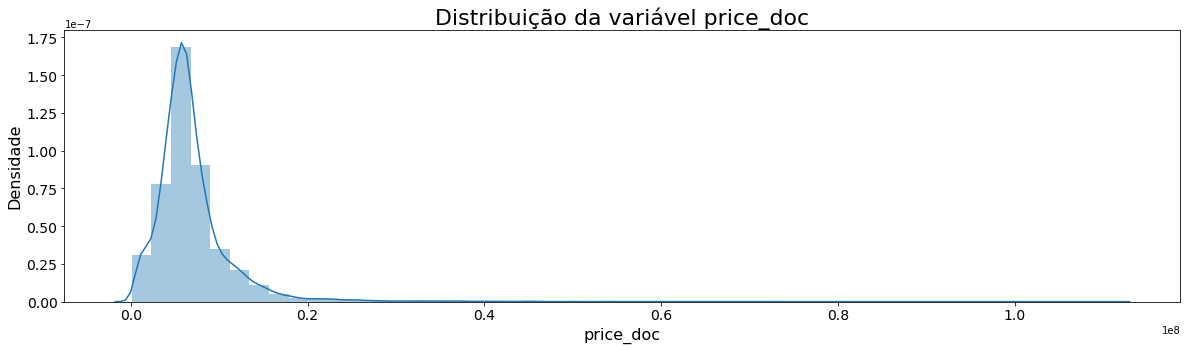

In [ ]:
# Avaliando a distribuição da variável _price_doc_
plt.figure(figsize=(20,5))
sns.distplot(dados_treino.price_doc)
plt.title('Distribuição da variável price_doc',size=22)
plt.xlabel('price_doc',size=16)
plt.ylabel('Densidade',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

Além da assimetria visível, temos uma distribuição em que os outliers podem prejudicar bastante o poder preditivo do nosso modelo linear.

Mas podemos realizar uma transformação bem simples para resolver esse problema, a `np.log`:

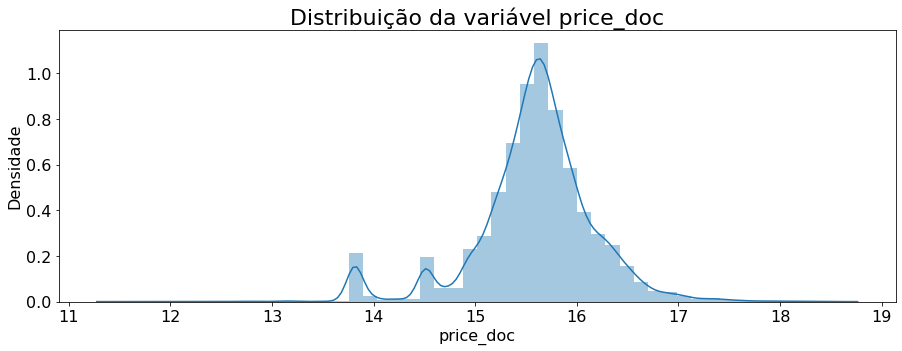

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(np.log(dados_treino.price_doc))
plt.title('Distribuição da variável price_doc',size=22)
plt.xlabel('price_doc',size=16)
plt.ylabel('Densidade',size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

O princípio por trás dessa transformação é a de que as variações possuirão proporções parecidas independentemente do valor do imóvel. O resultado disso é a conversão da nossa distribuição para `normal`!

## 7. Juntando tudo e organizando o nosso preprocessamento com `ColumnTransformer`

Aprendemos muitas etapas e técnicas de preprocessamento, tantas que nosso código final pode ser excessivamente complexo! Mas felizmente o `scikit-learn` possui uma função que permite encadear múltiplos processamentos, cada um aplicado a um conjunto diferente de features: o `ColumnTransformer`

In [ ]:
# Carregando a função
from sklearn.compose import ColumnTransformer

# Separando colunas numéricas e categóricas, EXCLUINDO a variável de interesse _price_doc_
cols_numericas = list(dados_treino.select_dtypes(include=['int64','float']).drop('price_doc',axis=1).columns)
cols_categoricas = ['state','material','nuclear_reactor_raion']

Essa função possui alguns parâmetros chave:
* `transformers`: Lista de tuplas que indicarão respectivamente o _nome_ do processo, a _função_ e a _lista de colunas_ para os quais aplicaremos a transformação:
    * Exemplo de tupla: `('funcao_escala',MinMaxScaler(),['life_sq'])` -> O processo `funcao_escala` aplicará a função `MinMaxScaler()` à coluna `life_sq`)
* `remainder`: Indica o que o processador fará com o restante (remainder) das colunas que não foram transformadas:
    * As opções mais comuns são `drop` (desconsiderar) e `passthrough` (não fazer nada e manter no dataset)
* `verbose_features_names_out`: Indica se queremos ou não as colunas com prefixos das operações usadas

In [ ]:
# Instanciando um ColumnTransformer
preprocessador = ColumnTransformer(transformers=[('funcao_escala',MinMaxScaler(),['life_sq'])],remainder='passthrough',
                                  verbose_feature_names_out=False)

# Aplicando o preprocessador na base de dados
dados_treino_preproc = preprocessador.fit_transform(dados_treino)

# Avaliando o array rbesultante
dados_treino_preproc 

array([[0.003610591067130248, '2011-08-20', 43, ..., 1.131259906,
        1.210027392, 5850000],
       [0.0025407863064990637, '2011-08-23', 34, ..., 0.635052534,
        2.72429538, 6000000],
       [0.0038780422572880445, '2011-08-27', 43, ..., 1.445959617,
        0.7722161040000001, 5700000],
       ...,
       [0.0038780422572880445, '2015-06-30', 56, ..., 0.709195943,
        2.538577994, 12000000],
       [0.007889810109654987, '2015-06-30', 86, ..., 0.7812173990000001,
        1.711271038, 25000000],
       [0.004279219042524739, '2015-06-30', 64, ..., 2.047312334,
        0.718679449, 13500000]], dtype=object)

Para convertermos o resultado em um `DataFrame`, precisamos apenas construí-lo com o resultado:

In [ ]:
# Convertendo o resultado em um dataframe
dados_treino_preproc = pd.DataFrame(dados_treino_preproc,columns=preprocessador.get_feature_names_out())
dados_treino_preproc.tail(3) # Últimos 5 registros

,life_sq,timestamp,full_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,nuclear_reactor_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,price_doc
23067,0.00387804,2015-06-30,56,13,14,1.0,2001,2,11,3.0,Severnoe Tushino,9.24924e+06,156377,3,0,5,no,53786,93843,16.6262,1.48671,2.23383,16.1547,0.709196,2.53858,12000000
23068,0.00788981,2015-06-30,86,3,9,2.0,1935,4,10,3.0,Tverskoe,7.30741e+06,75377,3,2,23,no,116742,43921,3.26928,1.23873,0.377368,1.01044,0.781217,1.71127,25000000
23069,0.00427922,2015-06-30,64,5,15,1.0,2003,2,11,2.0,Obruchevskoe,6.05006e+06,78616,2,1,4,no,83844,51445,13.6226,0.960608,4.89805,15.3033,2.04731,0.718679,13500000


Para aproveitar ao máximo o uso do `ColumnTransformer` e as estruturas de `.fit()` e `.transform()`, vamos também usar o conceito de **Pipeline**! Em um Pipeline, os passos são executados em sequência e retornam a nossa base transformada no fim:

<center> <img src="https://miro.medium.com/max/1378/0*0TrDLlBujC_IS-1y.png" width=1000>

In [ ]:
# Instanciando o pipeline
from sklearn.pipeline import Pipeline

preprocessamento_numericas = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('escala_features',RobustScaler()),
    ('feature_engineering',PolynomialFeatures(degree=2))
])
preprocessamento_categoricas = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(drop='first'))
]) 

Instanciando um `ColumnTransformer` final que incluir as etapas de pipeline definidas acima:

In [ ]:
preprocessador_final = ColumnTransformer(transformers=[
    ('tratando_as_numericas',preprocessamento_numericas,cols_numericas),
    ('tratando_as_categoricas',preprocessamento_categoricas,cols_categoricas),
],remainder='passthrough',verbose_feature_names_out=False)

dados_treino_prep = pd.DataFrame(preprocessador_final.fit_transform(dados_treino),
                                 columns=preprocessador_final.get_feature_names_out())

# Apresentando os dados processados
dados_treino_prep.head(3)

,1,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,healthcare_centers_raion,university_top_20_raion,shopping_centers_raion,full_all,work_all,kremlin_km,big_road1_km,railroad_km,zd_vokzaly_avto_km,metro_km_walk,radiation_km,full_sq^2,full_sq life_sq,full_sq floor,full_sq max_floor,full_sq build_year,full_sq num_room,full_sq kitch_sq,full_sq area_m,full_sq raion_popul,full_sq healthcare_centers_raion,full_sq university_top_20_raion,full_sq shopping_centers_raion,full_sq full_all,full_sq work_all,full_sq kremlin_km,full_sq big_road1_km,full_sq railroad_km,full_sq zd_vokzaly_avto_km,full_sq metro_km_walk,full_sq radiation_km,life_sq^2,life_sq floor,life_sq max_floor,life_sq build_year,life_sq num_room,life_sq kitch_sq,life_sq area_m,life_sq raion_popul,life_sq healthcare_centers_raion,life_sq university_top_20_raion,life_sq shopping_centers_raion,life_sq full_all,life_sq work_all,life_sq kremlin_km,life_sq big_road1_km,life_sq railroad_km,life_sq zd_vokzaly_avto_km,life_sq metro_km_walk,life_sq radiation_km,floor^2,floor max_floor,floor build_year,floor num_room,floor kitch_sq,floor area_m,floor raion_popul,floor healthcare_centers_raion,floor university_top_20_raion,floor shopping_centers_raion,floor full_all,floor work_all,floor kremlin_km,floor big_road1_km,floor railroad_km,floor zd_vokzaly_avto_km,floor metro_km_walk,floor radiation_km,max_floor^2,max_floor build_year,max_floor num_room,max_floor kitch_sq,max_floor area_m,max_floor raion_popul,max_floor healthcare_centers_raion,max_floor university_top_20_raion,max_floor shopping_centers_raion,max_floor full_all,max_floor work_all,max_floor kremlin_km,max_floor big_road1_km,max_floor railroad_km,max_floor zd_vokzaly_avto_km,max_floor metro_km_walk,max_floor radiation_km,build_year^2,build_year num_room,build_year kitch_sq,build_year area_m,build_year raion_popul,build_year healthcare_centers_raion,build_year university_top_20_raion,build_year shopping_centers_raion,build_year full_all,build_year work_all,build_year kremlin_km,build_year big_road1_km,build_year railroad_km,build_year zd_vokzaly_avto_km,build_year metro_km_walk,build_year radiation_km,num_room^2,num_room kitch_sq,num_room area_m,num_room raion_popul,num_room healthcare_centers_raion,num_room university_top_20_raion,num_room shopping_centers_raion,num_room full_all,num_room work_all,num_room kremlin_km,num_room big_road1_km,num_room railroad_km,num_room zd_vokzaly_avto_km,num_room metro_km_walk,num_room radiation_km,kitch_sq^2,kitch_sq area_m,kitch_sq raion_popul,kitch_sq healthcare_centers_raion,kitch_sq university_top_20_raion,kitch_sq shopping_centers_raion,kitch_sq full_all,kitch_sq work_all,kitch_sq kremlin_km,kitch_sq big_road1_km,kitch_sq railroad_km,kitch_sq zd_vokzaly_avto_km,kitch_sq metro_km_walk,kitch_sq radiation_km,area_m^2,area_m raion_popul,area_m healthcare_centers_raion,area_m university_top_20_raion,area_m shopping_centers_raion,area_m full_all,area_m work_all,area_m kremlin_km,area_m big_road1_km,area_m railroad_km,area_m zd_vokzaly_avto_km,area_m metro_km_walk,area_m radiation_km,raion_popul^2,raion_popul healthcare_centers_raion,raion_popul university_top_20_raion,raion_popul shopping_centers_raion,raion_popul full_all,raion_popul work_all,raion_popul kremlin_km,raion_popul big_road1_km,raion_popul railroad_km,raion_popul zd_vokzaly_avto_km,raion_popul metro_km_walk,raion_popul radiation_km,healthcare_centers_raion^2,healthcare_centers_raion university_top_20_raion,healthcare_centers_raion shopping_centers_raion,healthcare_centers_raion full_all,healthcare_centers_raion work_all,healthcare_centers_raion kremlin_km,healthcare_centers_raion big_road1_km,healthcare_centers_raion railroad_km,healthcare_centers_raion zd_vokzaly_avto_km,healthcare_centers_raion metro_km_walk,healthcare_centers_raion radiation_km,university_top_20_raion^2,university_top_20_raion shopping_centers_raion,university_top_20_raion full_all,university_top_20_raion work_all,university_top_2

Podemos até mesmo ver a estrutura do nosso processador:

In [ ]:
preprocessador_final

ColumnTransformer(remainder='passthrough',
                  transformers=[('tratando_as_numericas',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('escala_features',
                                                  RobustScaler()),
                                                 ('feature_engineering',
                                                  PolynomialFeatures())]),
                                 ['full_sq', 'life_sq', 'floor', 'max_floor',
                                  'build_year', 'num_room', 'kitch_sq',
                                  'area_m', 'raion_popul',
                                  'healthcare_centers_raion',...
                                  'shopping_centers_raion', 'full_all',
                                  'work_all', 'kremlin_km', 'big_road1_km',
                                  'railroad_km', 'zd_vokzaly_avto_km',
                                  'metro_km_walk', 'radiation_km']),
                                ('tratando_as_categoricas',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['state', 'material',
                                  'nuclear_reactor_raion'])],
                  verbose_feature_names_out=False)

## 8. Treinando nosso modelo!

Após todo o preprocessamento aplicado, vamos agora treinar uma regressão linear para tentarmos prever o valor do imóvel em função das suas características e da região em que ele se encontra:

In [ ]:
from sklearn.linear_model import LinearRegression

Assim como no `statsmodels`, também temos no `scikit-learn` algoritmos de regressão linear, é o que usaremos aqui. Para podermos usá-lo, precisamos seguir as etapas abaixo:
* Instanciar o modelo como um objeto
* Para treinarmos o modelo usando os dados disponíveis, usamos a função `.fit()`
* Para avaliarmos o resultado do modelo em qualquer conjunto de dados, podemos usar a função `.predict()`
* Podemos realizar as duas etapas ao mesmo tempo usando a função `.fit_predict()`

In [ ]:
from sklearn.linear_model import LinearRegression

# Apenas por simplicidade vamos excluir as colunas _timestamp_ e _sub_area_ dos nossos datasets
#dados_treino_prep.drop(['timestamp','sub_area'],axis=1,inplace=True)

# Separando em X e y 
X_treino = dados_treino_prep.drop('price_doc',axis=1)
y_treino = dados_treino_prep.price_doc

# Ajustando o nosso modelo aos dados, fornecendo X_treino e y_treino à função _fit_
modelo = LinearRegression()
modelo_linear = modelo.fit(X_treino,y_treino)
modelo_linear

LinearRegression()

Agora podemos prever o modelo em dados novos e inclusive avaliar a métrica **r2**, que também está implementada no `scikit-learn` como a função `r2_score`

In [ ]:
# Importando a métrica r2
from sklearn.metrics import r2_score

# Avaliando o modelo nos dados de treino
y_treino_predito = modelo_linear.predict(X_treino)

# Calculando a métrica r2
r2_treino = r2_score(y_treino,y_treino_predito)

print("A métrica R2 nos dados de treino foi de {:.3f}".format(r2_treino))

A métrica R2 nos dados de treino foi de 0.591


Nossa métrica foi muito boa em dados de treino! E podemos avaliá-la em dados que o modelo nunca viu:

In [ ]:
# Aplicando o mesmo preprocessamento dos dados de treino nos dados de teste (e construindo um DataFrame)
dados_teste_prep = pd.DataFrame(preprocessador_final.transform(dados_teste),
                                columns=preprocessador_final.get_feature_names_out()).drop(['timestamp','sub_area'],axis=1)

# Avaliando o resultado do modelo nos dados de teste
X_teste = dados_teste_prep.drop('price_doc',axis=1)
y_teste = dados_teste_prep.price_doc

# Avaliando o modelo e o r2 nos dados de teste
y_teste_predito = modelo_linear.predict(X_teste)
r2_teste = r2_score(y_teste,y_teste_predito)

print("A métrica R2 nos dados de treino foi de {:.3f}".format(r2_teste))

A métrica R2 nos dados de treino foi de 0.500


### Mas qual é de fato a importância de transformar nosso dataset?

O tratamento cuidadoso dos nossos dados podem ser determinantes para que a performance dos nossos modelos seja maximizada! Para ilustrar isso, vamos treinar alguns modelos, usando desde dados não transformados até dados totalmente transformados:

Antes de tudo, vamos automatizar nosso processo de treinar modelos e escorá-los, criando uma função para isso!

In [ ]:
def treina_modelos(dados_treino,dados_teste,transformador,log=False):
    # Treina o transformador nos dados de treino
    dados_treino_prep =  pd.DataFrame(transformador.fit_transform(dados_treino),
                                columns=transformador.get_feature_names_out()).drop(['timestamp','sub_area'],axis=1)
    dados_teste_prep = pd.DataFrame(transformador.transform(dados_teste),
                                columns=transformador.get_feature_names_out()).drop(['timestamp','sub_area'],axis=1)
    # Separa os dados em features e variável resposta
    X_treino = dados_treino_prep.drop('price_doc',axis=1)
    X_teste = dados_teste_prep.drop('price_doc',axis=1)
    if feature_engineering==True:
        X_treino = feat_eng(X_treino)
        X_teste = feat_eng(X_teste)
    if log==True:
        y_treino = np.log(dados_treino.price_doc)
        y_teste = np.log(dados_teste.price_doc)
    else:
        y_treino = dados_treino_prep.price_doc
        y_teste = dados_teste_prep.price_doc
    # Treina o modelo
    modelo = LinearRegression().fit(X_treino,y_treino)
    # Avalia o r2 nos dados de treino e de teste
    r2_treino = r2_score(y_treino,modelo.predict(X_treino))
    r2_teste = r2_score(y_teste,modelo.predict(X_teste))
    # Retorna os R2 de treino e teste
    return r2_treino, r2_teste   

Vamos agora fazer o processo de treinamento usando dois preprocessadores. O primeiro deles usará apenas o processo de preenchimento de valores faltantes:

In [ ]:
# Defionindo o transformador que apenas preenche missings

preprocessamento_numericas_simples = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
])
preprocessamento_categoricas_simples = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(drop='first'))
])

preprocessador_simples = ColumnTransformer(transformers=[
    ('processamento_numericas',preprocessamento_numericas_simples,cols_numericas),
    ('processamento_categoricas',preprocessamento_categoricas_simples,cols_categoricas),
],remainder='passthrough',verbose_feature_names_out=False)

# Ajustando o transformador
r2_treino_simples, r2_teste_simples = treina_modelos(dados_treino,dados_teste,preprocessador_simples,log=False)
print("Performance de treino - preprocessador simples: {:.3f}".format(r2_treino_simples))
print("Performance de teste - preprocessador simples: {:.3f}".format(r2_teste_simples))


Performance de treino - preprocessador simples: 0.325
Performance de teste - preprocessador simples: 0.401


Agora vamos treinar o modelo com o preprocessador _aplicando a transformação logaritmica_:

In [ ]:
# Definindo o transformador completo, com todas as etapas de preprocessamento!

preprocessamento_numericas_comlog = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('escala_features',RobustScaler()),
    ('feature_engineering',PolynomialFeatures(degree=2))
])
preprocessamento_categoricas_comlog = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(drop='first'))
])

preprocessador_comlog = ColumnTransformer(transformers=[
    ('processamento_numericas' ,preprocessamento_numericas_comlog,cols_numericas),
    ('processamento_categoricas',preprocessamento_categoricas_comlog,cols_categoricas),
],remainder='passthrough',verbose_feature_names_out=False)

# Ajustando o transformador
r2_treino_comlog, r2_teste_comlog = treina_modelos(dados_treino,dados_teste,preprocessador_comlog,log=True)
print("Performance de treino - preprocessador simples: {:.3f}".format(r2_treino_comlog))
print("Performance de teste - preprocessador simples: {:.3f}".format(r2_teste_comlog))


Performance de treino - preprocessador simples: 0.360
Performance de teste - preprocessador simples: 0.283


Agora vamos treinar o modelo com o preprocessador completo!:

In [ ]:
# Defionindo o transformador completo, com todas as etapas de preprocessamento!

preprocessamento_numericas_completo = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('escala_features',RobustScaler()),
    ('feature_engineering',PolynomialFeatures(degree=2))
])
preprocessamento_categoricas_completo = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(drop='first'))
])
  
preprocessador_completo = ColumnTransformer(transformers=[
    ('processamento_numericas',preprocessamento_numericas_completo,cols_numericas),
    ('processamento_categoricas',preprocessamento_categoricas_completo,cols_categoricas),
],remainder='passthrough',verbose_feature_names_out=False)

# Ajustando o transformador
r2_treino_completo, r2_teste_completo = treina_modelos(dados_treino,dados_teste,preprocessador_completo)
print("Performance de treino - preprocessador simples: {:.3f}".format(r2_treino_completo))
print("Performance de teste - preprocessador simples: {:.3f}".format(r2_teste_completo))


Performance de treino - preprocessador simples: 0.591
Performance de teste - preprocessador simples: 0.500


Comparando as métricas tanto no treino quanto no teste, podemos ver o impacto que temos ao fazer essa transformação:

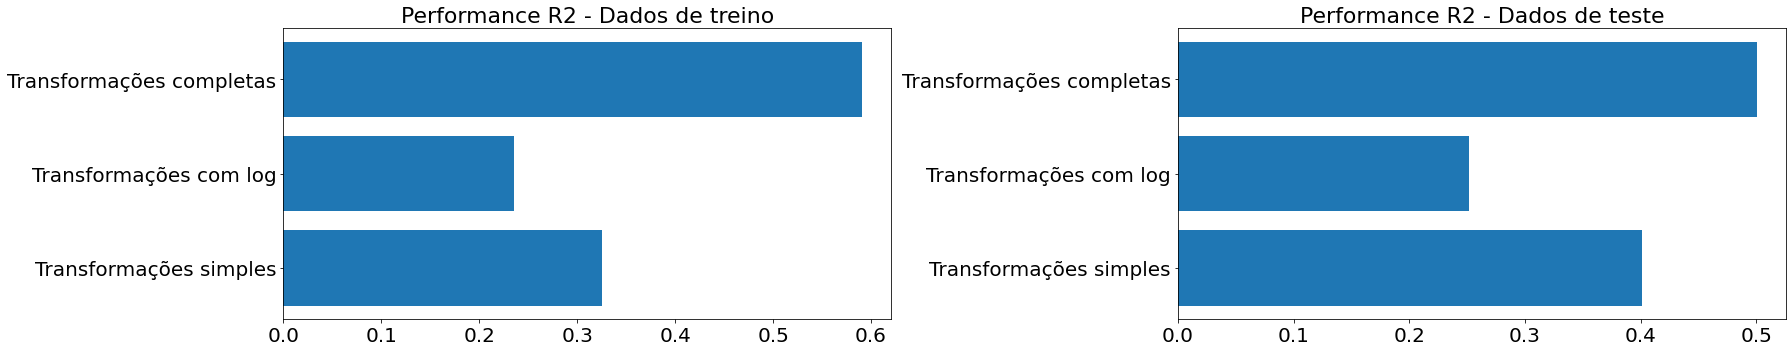

In [ ]:
nomes_modelos = ['Transformações simples','Transformações com log','Transformações completas']

# Gráfico com as métricas de treino e de teste
fig, ax = plt.subplots(1,2,figsize=(25,5))
ax[0].barh(y=nomes_modelos,width=[r2_treino_simples,r2_treino_comlog,r2_treino_completo])
ax[1].barh(y=nomes_modelos,width=[r2_teste_simples,r2_teste_comlog,r2_teste_completo])
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_title('Performance R2 - Dados de treino',size=22)
ax[1].set_title('Performance R2 - Dados de teste',size=22)
plt.tight_layout()
plt.show()

Quase dobramos o valor do `R2` original através da transformação dos dados!

## 10. Recapitulando o que fizemos, e mais sugestões!





* Entendemos os dados à disposição, seus formatos e tipos
* Fizemos o tratamento de missings, usando para isso funçoes do `scikit-learn` como o `SimpleImputer`
* Aprendemos a lidar com outliers, com o auxílio de funções como `z-score` e `IQR`
* Normalizamos as features a partir de funções de escala como `MinMaxScaler`, `StandardScaler` e `RobustScaler`
* Também aprendemos a converter variáveis categóricas em numéricas usando `OneHotEncoding`
* Construimos novas features a partir das originais usando conhecimento do problema e também polinômios usando o `PolynomialFeatures`
* Sintetizamos todas as transformações usando `ColumnTransformer` e `Pipelines`, e usamos as bases transformadas para treinarmos modelos de regressão linear com o `LinearRegression`, do `scikit-learn`




### Foi uma longa jornada, mas conseguimos cumprí-la! Vou deixar algumas referências bacanas para checarem depois, relacionado ao que fizemos!

<center> <img src = "../0. MISC/dmitri.gif" width=700> </center>

* Neste [artigo](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4) do Towards Data Science vocês poderão aprender também outras técnicas de consideração de missings nos Datasets, com mais possibilidades de imputação e também os tradeoffs das técnicas.
* Indico também um [livro bem legal](https://www.amazon.com.br/dp/B07BNX4MWC/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1) que fala somente de `Feature Engineering`, que pode ser determinante nos seus problemas!
 

# <center> Muito obrigado a todos!!!
    
<center> <img src="https://s.studiobinder.com/wp-content/uploads/2020/07/Michael-Scott-Wayne-Gretzsky-Quotes.jpg?resolution=1680,0.75" width=1500>